In [1]:
library("rstan")
library("dplyr")
library("tidyr")
library("ggplot2")
library("pracma")
library("abind")
library("reshape2")
library("ggtext")
library('tidyverse')
library('scales')

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:rstan’:

    extract



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts()

In [2]:
options(scipen = 10000)

# Function

In [3]:
MAPE = function(y, ypred){
    mean( abs(y-ypred)/abs(y) )*100
}
#variation
rsquared = function(y, ypred){
    tot = sum((y-mean(y))^2)
    res = sum((y-ypred)^2)
    1-(res/tot)
}

In [4]:
source('Optimization_functions/common_functions_mmm.R')
source('Optimization_functions/generate_quarterly_mix_from_lists.R')

# load data

In [5]:
##Load model params and optimization results
load('model_params/model_params_NP_22_00_C12_3y_email_cntrl.rda')
load('RData/data_XyZ_v1.RData')
load('RData/pp_MMM_email_cntrl.RData')

In [6]:
nbr_period_q <- 13

In [7]:
data_XyZ <- get_quarters(data_XyZ)

`summarise()` has grouped output by 'dma'. You can override using the `.groups` argument.



In [8]:
Z = model_params$control_params$control_mat

In [9]:
nbr_periods = nrow(data_XyZ %>% distinct(period))

In [10]:
prospect_mat_media = model_params$media_params$prospect_mat_media
target_capita_norm_col = model_params$target_params$target_capita_norm_col

In [11]:
dma_names_vec = model_params$other_params$dma_names_vec

In [12]:
var_id_opt <- which(dma_names_vec %in% model_params$other_params$optimum_dma)
var_id_opt

[1] 17

In [13]:
nbr_dma = length(dma_names_vec)
nbr_period_q = model_params$other_params$nbr_period_q

In [14]:
media_names_vec = model_params$media_params$media_names_vec
cleaned_names_list = model_params$media_params$cleaned_names_list
spend_cols_vec = model_params$media_params$spend_cols_vec

In [15]:
max_actual_df = model_params$media_params$max_media_mat
min_actual_df = model_params$media_params$min_media_mat

In [16]:
spend_activity_ratio_dma_df = model_params$media_params$spend_activity_ratio_dma_df

In [17]:
S = model_params$media_params$S
K = model_params$media_params$K
alpha_vec = model_params$media_params$alpha
beta_media_mat = model_params$media_params$beta_media_mat
beta_control_mat = model_params$control_params$beta_control_mat
#pred = get_posterior_mean(fit, pars = c("pred"))[,nbr_chains+1]

In [18]:
nbr_media = length(media_names_vec)

In [19]:
control_names_vec <- model_params$control_params$control_names_vec
control_names_vec

[1] "intercept"             "seasonality_gross_add" "MA_4"                 
 [4] "price_ARPU_fprint"     "comp_index"            "weather1"             
 [7] "weather5"              "promotion"             "mega_holiday"         
[10] "covid_daily_deaths"    "AR2"                   "AR4"                  
[13] "SNOW"                  "covid_dummy"           "email_sent_w"

In [20]:
y_max = model_params$target_params$target_max_vec

In [21]:
head(data_XyZ)

,brand,dma,period,gross_add,dma_insertable_proj_grps,dma_insertable_ue,cross_channel_imp,cross_channel_spend,dm_volume,dm_spend,⋯,ad_messenger_campaign,covid_dummy,price_OPT,price_SDL,price_ARPU_fprint,price_ARPU,price_hybrid,year,quarter,qy
,<chr>,<chr>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,Suddenlink,"ABILENE, TX",2017-12-31,7,70.285284,22364,15719,690.85005,0,0.00,⋯,0,0,0,235.3187,125.4588,116.73,235.3187,2017,Q1,Q1_2018
2,Suddenlink,"ABILENE, TX",2018-01-07,8,58.911590,22364,13175,579.04125,0,0.00,⋯,0,0,0,235.3187,141.3848,203.83,235.3187,2018,Q1,Q1_2018
3,Suddenlink,"ABILENE, TX",2018-01-14,13,58.911590,22364,13175,579.04125,0,0.00,⋯,0,0,0,235.3187,135.0656,125.37,235.3187,2018,Q1,Q1_2018
4,Suddenlink,"ABILENE, TX",2018-01-21,12,9.001036,22364,2013,88.47135,0,0.00,⋯,0,0,0,235.3187,136.5128,181.18,235.3187,2018,Q1,Q1_2018
5,Suddenlink,"ABILENE, TX",2018-01-28,11,0.000000,22244,0,0.00000,0,0.00,⋯,0,0,0,235.3187,144.7575,142.96,235.3187,2018,Q1,Q1_2018
6,Suddenlink,"ABILENE, TX",2018-02-04,13,38.585689,22086,8522,374.54190,2698,701.48,⋯,0,0,0,235.3187,131.4760,192.79,235.3187,2018,Q1,Q1_2018


In [22]:
dma_info_data <- pp_MMM_email_cntrl$extra$df_dma

In [23]:
data_XyZ <- data_XyZ %>% 
            dplyr::left_join(dma_info_data,by = 'dma')

data_XyZ

brand,dma,period,gross_add,dma_insertable_proj_grps,dma_insertable_ue,cross_channel_imp,cross_channel_spend,dm_volume,dm_spend,⋯,covid_dummy,price_OPT,price_SDL,price_ARPU_fprint,price_ARPU,price_hybrid,year,quarter,qy,dma_id
<chr>,<chr>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
Suddenlink,"ABILENE, TX",2017-12-31,7,70.285284,22364,15719,690.85005,0,0.00,⋯,0,0,235.3187,125.4588,116.73,235.3187,2017,Q1,Q1_2018,1
Suddenlink,"ABILENE, TX",2018-01-07,8,58.911590,22364,13175,579.04125,0,0.00,⋯,0,0,235.3187,141.3848,203.83,235.3187,2018,Q1,Q1_2018,1
Suddenlink,"ABILENE, TX",2018-01-14,13,58.911590,22364,13175,579.04125,0,0.00,⋯,0,0,235.3187,135.0656,125.37,235.3187,2018,Q1,Q1_2018,1
Suddenlink,"ABILENE, TX",2018-01-21,12,9.001036,22364,2013,88.47135,0,0.00,⋯,0,0,235.3187,136.5128,181.18,235.3187,2018,Q1,Q1_2018,1
Suddenlink,"ABILENE, TX",2018-01-28,11,0.000000,22244,0,0.00000,0,0.00,⋯,0,0,235.3187,144.7575,142.96,235.3187,2018,Q1,Q1_2018,1
Suddenlink,"ABILENE, TX",2018-02-04,13,38.585689,22086,8522,374.54190,2698,701.48,⋯,0,0,235.3187,131.4760,192.79,235.3187,2018,Q1,Q1_2018,1
Suddenlink,"ABILENE, TX",2018-02-11,17,50.433809,22086,11139,489.55905,0,0.00,⋯,0,0,235.3187,148.0353,208.55,235.3187,2018,Q1,Q1_2018,1
Suddenlink,"ABILENE, TX",2018-02-18,6,82.451721,22086,18210,800.32950,2698,701.48,⋯,0,0,235.3187,132.0320,190.91,235.3187,2018,Q1,Q1_2018,1
Suddenlink,"ABILENE, TX",2018-02-25,11,50.969298,22104,11266,495.14070,0,0.00,⋯,0,0,235.3187,153.7438,112.73,235.3187,2018,Q1,Q1_2018,1


In [24]:
##Extract normalized control and media dataframes
Z_norm <- pp_MMM_email_cntrl$control$Z_per_capita %>% 
          dplyr::mutate(intercept = 1) %>%
          dplyr::select(period,dma,control_names_vec)

Z_norm

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(control_names_vec)` instead of `control_names_vec` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



period,dma,intercept,seasonality_gross_add,MA_4,price_ARPU_fprint,comp_index,weather1,weather5,promotion,mega_holiday,covid_daily_deaths,AR2,AR4,SNOW,covid_dummy,email_sent_w
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-12-31,"ABILENE, TX",1,0.3576781,0.1923077,0.220326884,0.00000000,0.6243054,0.130683672,0,1,0,0.40,0.36,0.00000000,0,0.0000000
2018-01-07,"ABILENE, TX",1,0.3926446,0.2500000,0.361413985,0.00000000,0.5438551,0.102183236,0,0,0,0.24,0.44,0.00000000,0,0.0000000
2018-01-14,"ABILENE, TX",1,0.5141123,0.3269231,0.305432064,0.00000000,0.5527934,0.118603395,0,1,0,0.16,0.40,0.00000000,0,0.0000000
2018-01-21,"ABILENE, TX",1,0.3933767,0.4230769,0.318252885,0.00000000,0.5188550,0.099111423,0,0,0,0.20,0.24,0.00000000,0,0.0000000
2018-01-28,"ABILENE, TX",1,0.6532462,0.5000000,0.391291907,0.00000000,0.5538025,0.093643065,0,0,0,0.40,0.16,0.00000000,0,0.0000000
2018-02-04,"ABILENE, TX",1,0.8447505,0.3846154,0.273632394,0.00000000,0.5892446,0.110626794,0,0,0,0.36,0.20,0.00000000,0,0.0000000
2018-02-11,"ABILENE, TX",1,0.4999475,0.3846154,0.420329595,0.00000000,0.5693184,0.138102081,0,0,0,0.32,0.40,0.00000000,0,0.0000000
2018-02-18,"ABILENE, TX",1,0.3281469,0.2692308,0.278558126,0.00000000,0.5329564,0.408796248,0,1,0,0.40,0.36,0.05390285,0,0.0000000
2018-02-25,"ABILENE, TX",1,0.7791547,0.1923077,0.470900340,0.00000000,0.6205772,0.111835151,0,0,0,0.56,0.32,0.00000000,0,0.0000000


In [25]:
media_norm <- pp_MMM_email_cntrl$media$X_norm2 %>%
              dplyr::select(period,dma,spend_cols_vec) %>%
              dplyr::rename_at(.vars = vars(spend_cols_vec),.funs = ~media_names_vec)

media_norm

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(spend_cols_vec)` instead of `spend_cols_vec` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



period,dma,digital,DRTV_w,radio_w,social,dm,paid_search,cross_channel_imp
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-12-31,"ABILENE, TX",0.010986547,0.0000000,0.00000000,0.009161643,0.0000000,0.0001883207,0.17161230
2018-01-07,"ABILENE, TX",0.013753657,0.0000000,0.00000000,0.010084182,0.0000000,0.0276528320,0.14383816
2018-01-14,"ABILENE, TX",0.023590003,0.0000000,0.00000000,0.010512593,0.0000000,0.0083207425,0.14383816
2018-01-21,"ABILENE, TX",0.023316556,0.0000000,0.00000000,0.011640882,0.0000000,0.0096995961,0.02197694
2018-01-28,"ABILENE, TX",0.027070736,0.0000000,0.00000000,0.016821751,0.0000000,0.0038897956,0.00000000
2018-02-04,"ABILENE, TX",0.024411591,0.0000000,0.00000000,0.022748887,0.1518427,0.0175506193,0.09303900
2018-02-11,"ABILENE, TX",0.020547337,0.0000000,0.16856456,0.026404563,0.0000000,0.0040456472,0.12161011
2018-02-18,"ABILENE, TX",0.021018598,0.0000000,0.00000000,0.025933384,0.1518427,0.0144335877,0.19880781
2018-02-25,"ABILENE, TX",0.022149529,0.0000000,0.19029517,0.019867443,0.0000000,0.0232262142,0.12299664


In [26]:
X_Z_norm <- media_norm %>%
            dplyr::left_join(Z_norm,by = c('period','dma'))

X_Z_norm

period,dma,digital,DRTV_w,radio_w,social,dm,paid_search,cross_channel_imp,intercept,⋯,weather1,weather5,promotion,mega_holiday,covid_daily_deaths,AR2,AR4,SNOW,covid_dummy,email_sent_w
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-12-31,"ABILENE, TX",0.010986547,0.0000000,0.00000000,0.009161643,0.0000000,0.0001883207,0.17161230,1,⋯,0.6243054,0.130683672,0,1,0,0.40,0.36,0.00000000,0,0.0000000
2018-01-07,"ABILENE, TX",0.013753657,0.0000000,0.00000000,0.010084182,0.0000000,0.0276528320,0.14383816,1,⋯,0.5438551,0.102183236,0,0,0,0.24,0.44,0.00000000,0,0.0000000
2018-01-14,"ABILENE, TX",0.023590003,0.0000000,0.00000000,0.010512593,0.0000000,0.0083207425,0.14383816,1,⋯,0.5527934,0.118603395,0,1,0,0.16,0.40,0.00000000,0,0.0000000
2018-01-21,"ABILENE, TX",0.023316556,0.0000000,0.00000000,0.011640882,0.0000000,0.0096995961,0.02197694,1,⋯,0.5188550,0.099111423,0,0,0,0.20,0.24,0.00000000,0,0.0000000
2018-01-28,"ABILENE, TX",0.027070736,0.0000000,0.00000000,0.016821751,0.0000000,0.0038897956,0.00000000,1,⋯,0.5538025,0.093643065,0,0,0,0.40,0.16,0.00000000,0,0.0000000
2018-02-04,"ABILENE, TX",0.024411591,0.0000000,0.00000000,0.022748887,0.1518427,0.0175506193,0.09303900,1,⋯,0.5892446,0.110626794,0,0,0,0.36,0.20,0.00000000,0,0.0000000
2018-02-11,"ABILENE, TX",0.020547337,0.0000000,0.16856456,0.026404563,0.0000000,0.0040456472,0.12161011,1,⋯,0.5693184,0.138102081,0,0,0,0.32,0.40,0.00000000,0,0.0000000
2018-02-18,"ABILENE, TX",0.021018598,0.0000000,0.00000000,0.025933384,0.1518427,0.0144335877,0.19880781,1,⋯,0.5329564,0.408796248,0,1,0,0.40,0.36,0.05390285,0,0.0000000
2018-02-25,"ABILENE, TX",0.022149529,0.0000000,0.19029517,0.019867443,0.0000000,0.0232262142,0.12299664,1,⋯,0.6205772,0.111835151,0,0,0,0.56,0.32,0.00000000,0,0.0000000


## Time series slide

In [27]:
load('RData/Pred_vs_Actual_TS_data.RData')

In [28]:
pivot_table_ts <- ts_data %>%
filter(group %in% c('Altice','Optimum','Suddenlink')) %>%
mutate(Mean = round(Mean),
       period = as.Date(period)) %>%
select(period,group,Actual = y_true,Predicted = Mean) %>%
tidyr::pivot_wider(names_from = group, values_from = c(Actual,Predicted))
pivot_table_ts

period,Actual_Altice,Actual_Optimum,Actual_Suddenlink,Predicted_Altice,Predicted_Optimum,Predicted_Suddenlink
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-09-30,1277,822,455,1269,813,456
2018-10-07,1340,865,475,1290,840,450
2018-10-14,1336,834,502,1327,861,466
2018-10-21,1342,926,416,1352,874,478
2018-10-28,1370,897,473,1324,896,428
2018-11-04,1363,940,423,1185,807,379
2018-11-11,1185,801,384,1174,798,376
2018-11-18,755,498,257,924,625,300
2018-11-25,1427,934,493,1192,807,386


In [29]:
write.csv(pivot_table_ts,'Actual_vs_Predicted.csv',row.names = F)

In [30]:
colors <- c("Altice Actual" = "black", "Altice Predicted" = "gray", 
            "Optimum Actual" = "blue", "Optimum Predicted" = "sky blue", 
            "Suddenlink Actual" = "dark green", "Suddenlink Predicted" = "light green")

In [31]:
options(repr.plot.width=16, repr.plot.height = 8) 
ts_plt <- pivot_table_ts %>%
ggplot(.,aes(x = period)) +
geom_line(aes(y = Actual_Altice, color = 'Altice Actual')) +
geom_line(aes(y = Predicted_Altice,color = 'Altice Predicted')) +
geom_line(aes(y = Actual_Optimum, color = 'Optimum Actual')) +
geom_line(aes(y = Predicted_Optimum,color = 'Optimum Predicted')) +
geom_line(aes(y = Actual_Suddenlink, color = 'Suddenlink Actual')) +
geom_line(aes(y = Predicted_Suddenlink,color = 'Suddenlink Predicted')) +
ggthemes::theme_few() +
labs(y = "True Gross Adds") +
scale_x_date(labels = date_format("%b%y"),breaks = "2 months") +
scale_color_manual(values = colors) +
theme(legend.position = 'none',
     #axis.title.y=element_blank(),
     axis.title.x = element_blank(),
      axis.text.x = element_text(angle = 90))

ggsave(filename = 'Actual_vs_Predicted.png',plot = ts_plt,width = 10,height=5,units = 'in')

# Method 2

In [32]:
var_optimization_lb = 0.7
var_optimization_ub = 1.3

In [33]:
id<-rep(1:nbr_dma,each=nbr_periods) 

In [34]:
load('RData/Mean_Spend_Data_full_data.rda')

In [35]:
mean_spend_data

digital,DRTV_w,radio_w,social,dm,paid_search,cross_channel_imp
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
283.1875,2575.4130,767.6311,318.0565,588.8557,159.92775,20122.302
276.9538,3345.7706,620.5162,310.0880,469.5496,158.31093,33840.811
2725.9849,8434.5358,2016.3727,1476.6136,1029.7128,1183.85434,36866.191
431.0701,4443.8246,1453.7632,496.5787,1070.3556,233.62808,40364.567
1143.2468,0.0000,0.0000,402.7882,456.2971,618.03418,35329.942
422.3291,1556.8355,494.8940,373.1824,428.0977,180.46571,92039.489
1152.1826,3455.3942,1206.3523,1001.3835,986.6772,562.46088,223999.076
3611.3113,0.0000,2873.6538,1469.9069,1051.0330,1851.57033,5428.961
287.0513,539.9053,171.6276,124.1873,314.8960,84.43456,20972.305


In [36]:
mean_media_mat <- mean_spend_data

In [37]:
mean_media_mat

digital,DRTV_w,radio_w,social,dm,paid_search,cross_channel_imp
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
283.1875,2575.4130,767.6311,318.0565,588.8557,159.92775,20122.302
276.9538,3345.7706,620.5162,310.0880,469.5496,158.31093,33840.811
2725.9849,8434.5358,2016.3727,1476.6136,1029.7128,1183.85434,36866.191
431.0701,4443.8246,1453.7632,496.5787,1070.3556,233.62808,40364.567
1143.2468,0.0000,0.0000,402.7882,456.2971,618.03418,35329.942
422.3291,1556.8355,494.8940,373.1824,428.0977,180.46571,92039.489
1152.1826,3455.3942,1206.3523,1001.3835,986.6772,562.46088,223999.076
3611.3113,0.0000,2873.6538,1469.9069,1051.0330,1851.57033,5428.961
287.0513,539.9053,171.6276,124.1873,314.8960,84.43456,20972.305


In [38]:
X_norm_lag <- pp_MMM_email_cntrl$media$X_norm2_array

In [39]:
dim(X_norm_lag)

[1] 5850    7   14

In [40]:
nbr_periods

[1] 195

In [41]:
#Hill and Adstock Media
media_adstock_hill = data.frame(hill(adStockGeom(idx_media = 1, alpha = alpha_vec[1],input_data = X_norm_lag,nbr_periods,nbr_dma), K = K[1], S = S[1]))

for(idx in 2:nbr_media){
media_adstock_hill = data.frame(media_adstock_hill, 
                                hill(adStockGeom(idx_media = idx, alpha = alpha_vec[idx],input_data = X_norm_lag,nbr_periods,nbr_dma), K = K[idx], S = S[idx]))
                                }
colnames(media_adstock_hill) <- media_names_vec

In [42]:
K

[1] 0.8747084 0.8675770 0.8487741 0.8704651 0.7699129 0.8570566 0.8874128

In [43]:
dim(media_adstock_hill)

[1] 5850    7

In [44]:
period_df <- data_XyZ %>%
             arrange(dma,period) %>%
             select(period,dma)

In [45]:
#Gross adds by media, by week and by DMA
media_adstock_hill_target = array(rep(0, nbr_dma*nbr_periods*nbr_media), dim = c(nbr_dma*nbr_periods, nbr_media))
for(n in 1:(nbr_dma*nbr_periods)){
    for(media in 1:nbr_media){
    media_adstock_hill_target[n, media] = media_adstock_hill[n,media]*beta_media_mat[id[n],media]*y_max[id[n]]*prospect_mat_media[id[n],media]
    }
}
colnames(media_adstock_hill_target) <- media_names_vec

In [46]:
media_adstock_hill_target <- data.frame(media_adstock_hill_target) 

In [47]:
media_adstock_hill_target_df <- cbind(period_df,media_adstock_hill_target) %>%
                                rename_at(.vars = vars(media_names_vec),.funs = function(x){paste(x,'ga',sep='_')})

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(media_names_vec)` instead of `media_names_vec` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



In [48]:
media_adstock_hill_target_df

period,dma,digital_ga,DRTV_w_ga,radio_w_ga,social_ga,dm_ga,paid_search_ga,cross_channel_imp_ga
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-12-31,"ABILENE, TX",0.0000003315655,0.000000000,0.000000000000,0.0000001326877,0.000000000,0.0000000000008938217,0.0006615249
2018-01-07,"ABILENE, TX",0.0000027610455,0.000000000,0.000000000000,0.0000009123299,0.000000000,0.0000126961703052157,0.0028212100
2018-01-14,"ABILENE, TX",0.0000188050502,0.000000000,0.000000000000,0.0000023476478,0.000000000,0.0000090208588231364,0.0058911297
2018-01-21,"ABILENE, TX",0.0000414641139,0.000000000,0.000000000000,0.0000045707339,0.000000000,0.0000087083172197625,0.0023813016
2018-01-28,"ABILENE, TX",0.0000792703593,0.000000000,0.000000000000,0.0000114575401,0.000000000,0.0000035063966403462,0.0007057665
2018-02-04,"ABILENE, TX",0.0000971948999,0.000000000,0.000000000000,0.0000298564185,0.015431742,0.0000144287897203410,0.0014194213
2018-02-11,"ABILENE, TX",0.0000883566318,0.000000000,0.002219629163,0.0000626542734,0.004367609,0.0000053939784171272,0.0031258265
2018-02-18,"ABILENE, TX",0.0000854500117,0.000000000,0.000577171729,0.0000939712907,0.039022917,0.0000120436189558179,0.0104512436
2018-02-25,"ABILENE, TX",0.0000893759497,0.000000000,0.010184549630,0.0000903307854,0.011053281,0.0000411931590309857,0.0109705105


In [49]:
spend_cols_vec

[1] "digital_spend"     "DRTV_spend_w"      "radio_spend_w"    
[4] "social_spend"      "dm_spend"          "paid_search_spend"
[7] "cross_channel_imp"

In [50]:
media_spend_target <- data_XyZ %>%
                      select(period,dma,spend_cols_vec) %>%
                      rename_at(.vars = vars(spend_cols_vec), .funs = ~paste(media_names_vec,'Spend',sep = '_')) %>%
                      left_join(media_adstock_hill_target_df, by = c('dma','period'))

In [51]:
media_spend_target

period,dma,digital_Spend,DRTV_w_Spend,radio_w_Spend,social_Spend,dm_Spend,paid_search_Spend,cross_channel_imp_Spend,digital_ga,DRTV_w_ga,radio_w_ga,social_ga,dm_ga,paid_search_ga,cross_channel_imp_ga
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-12-31,"ABILENE, TX",50.75543,0.000,0.0000,42.32477,0.00,0.87,15719,0.0000003315655,0.000000000,0.000000000000,0.0000001326877,0.000000000,0.0000000000008938217,0.0006615249
2018-01-07,"ABILENE, TX",63.53887,0.000,0.0000,46.58670,0.00,127.75,13175,0.0000027610455,0.000000000,0.000000000000,0.0000009123299,0.000000000,0.0000126961703052157,0.0028212100
2018-01-14,"ABILENE, TX",108.98063,0.000,0.0000,48.56586,0.00,38.44,13175,0.0000188050502,0.000000000,0.000000000000,0.0000023476478,0.000000000,0.0000090208588231364,0.0058911297
2018-01-21,"ABILENE, TX",107.71736,0.000,0.0000,53.77831,0.00,44.81,2013,0.0000414641139,0.000000000,0.000000000000,0.0000045707339,0.000000000,0.0000087083172197625,0.0023813016
2018-01-28,"ABILENE, TX",125.06085,0.000,0.0000,77.71279,0.00,17.97,0,0.0000792703593,0.000000000,0.000000000000,0.0000114575401,0.000000000,0.0000035063966403462,0.0007057665
2018-02-04,"ABILENE, TX",112.77618,0.000,0.0000,105.09485,701.48,81.08,8522,0.0000971948999,0.000000000,0.000000000000,0.0000298564185,0.015431742,0.0000144287897203410,0.0014194213
2018-02-11,"ABILENE, TX",94.92418,0.000,778.7312,121.98327,0.00,18.69,11139,0.0000883566318,0.000000000,0.002219629163,0.0000626542734,0.004367609,0.0000053939784171272,0.0031258265
2018-02-18,"ABILENE, TX",97.10130,0.000,0.0000,119.80653,701.48,66.68,18210,0.0000854500117,0.000000000,0.000577171729,0.0000939712907,0.039022917,0.0000120436189558179,0.0104512436
2018-02-25,"ABILENE, TX",102.32595,0.000,879.1218,91.78321,0.00,107.30,11266,0.0000893759497,0.000000000,0.010184549630,0.0000903307854,0.011053281,0.0000411931590309857,0.0109705105


In [52]:
lb_df = data.frame('dma' = dma_names_vec,mean_media_mat*var_optimization_lb/spend_activity_ratio_dma_df) %>%
        rename_at(.vars = vars(media_names_vec), .funs = ~paste(media_names_vec,'LB',sep = '_'))
lb_df

dma,digital_LB,DRTV_w_LB,radio_w_LB,social_LB,dm_LB,paid_search_LB,cross_channel_imp_LB
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"ABILENE, TX",198.23122,1802.789,537.3418,222.63955,412.1990,111.94942,14085.611
"ALEXANDRIA, LA",193.86769,2342.039,434.3613,217.06160,328.6847,110.81765,23688.567
ALL OTHER SUDDENLINK DMA TOTAL,1908.18940,5904.175,1411.4609,1033.62950,720.7989,828.69804,25806.333
"AMARILLO, TX",301.74909,3110.677,1017.6343,347.60507,749.2489,163.53965,28255.197
"AUSTIN, TX",800.27277,NaN,NaN,281.95174,319.4079,432.62392,24730.960
"BLUEFIELD-BECKLEY, WV",295.63039,Inf,Inf,261.22770,299.6684,126.32600,64427.643
"CHARLESTON-HUNTINGTON, WV",806.52781,Inf,844.4466,700.96843,690.6740,393.72262,156799.353
"DALLAS, TX",2527.91791,NaN,2011.5577,1028.93485,735.7231,1296.09923,3800.273
"EUREKA, CA",200.93592,Inf,Inf,86.93114,220.4272,59.10419,14680.614


In [53]:
ub_df = data.frame('dma' = dma_names_vec,mean_media_mat*var_optimization_ub/spend_activity_ratio_dma_df) %>%
        rename_at(.vars = vars(media_names_vec), .funs = ~paste(media_names_vec,'UB',sep = '_'))
ub_df

dma,digital_UB,DRTV_w_UB,radio_w_UB,social_UB,dm_UB,paid_search_UB,cross_channel_imp_UB
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"ABILENE, TX",368.1437,3348.037,997.9204,413.4734,765.5124,207.9061,26158.99
"ALEXANDRIA, LA",360.0400,4349.502,806.6710,403.1144,610.4145,205.8042,43993.05
ALL OTHER SUDDENLINK DMA TOTAL,3543.7803,10964.897,2621.2845,1919.5976,1338.6266,1539.0106,47926.05
"AMARILLO, TX",560.3912,5776.972,1889.8922,645.5523,1391.4623,303.7165,52473.94
"AUSTIN, TX",1486.2209,NaN,NaN,523.6247,593.1862,803.4444,45928.92
"BLUEFIELD-BECKLEY, WV",549.0279,Inf,Inf,485.1372,556.5270,234.6054,119651.34
"CHARLESTON-HUNTINGTON, WV",1497.8374,Inf,1568.2580,1301.7985,1282.6803,731.1991,291198.80
"DALLAS, TX",4694.7047,NaN,3735.7500,1910.8790,1366.3430,2407.0414,7057.65
"EUREKA, CA",373.1667,Inf,Inf,161.4436,409.3648,109.7649,27264.00


In [54]:
media_spend_target <- media_spend_target %>%
                      left_join(lb_df,by = 'dma') %>%
                      left_join(ub_df, by = 'dma') %>%
                      mutate(brand = ifelse(dma%in%model_params$other_params$optimum_dma,'Optimum','Suddenlink'))%>%
                      group_by(dma) %>%
                      mutate(Index = row_number()) 


In [55]:
glimpse(media_spend_target)

Rows: 5,850
Columns: 32
Groups: dma [30]
$ period                  <date> 2017-12-31, 2018-01-07, 2018-01-14, 2018-01-2…
$ dma                     <chr> "ABILENE, TX", "ABILENE, TX", "ABILENE, TX", "…
$ digital_Spend           <dbl> 50.75543, 63.53887, 108.98063, 107.71736, 125.…
$ DRTV_w_Spend            <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.00…
$ radio_w_Spend           <dbl> 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000…
$ social_Spend            <dbl> 42.32477, 46.58670, 48.56586, 53.77831, 77.712…
$ dm_Spend                <dbl> 0.00, 0.00, 0.00, 0.00, 0.00, 701.48, 0.00, 70…
$ paid_search_Spend       <dbl> 0.87, 127.75, 38.44, 44.81, 17.97, 81.08, 18.6…
$ cross_channel_imp_Spend <dbl> 15719, 13175, 13175, 2013, 0, 8522, 11139, 182…
$ digital_ga              <dbl> 0.0000003315655, 0.0000027610455, 0.0000188050…
$ DRTV_w_ga               <dbl> 0.000000000, 0.000000000, 0.000000000, 0.00000…
$ radio_w_ga              <dbl> 0.000000000000, 0.000000000000, 0.000000000000…

In [56]:
period_df <- data_XyZ %>%
             select(period,dma,brand,qy,quarter,year)

In [57]:
media_spend_target1 <- media_spend_target %>%
                       left_join(period_df)

Joining, by = c("period", "dma", "brand")



In [58]:
load('RData/Simulated_Results_Q32022_v2.rda')

In [59]:
opt_target_qy = 'Q3_2022'
quarter_2_optimize = 'Q3 2022'

In [60]:
start_date <- as.Date(max(data_XyZ$period)) + lubridate::weeks(1)
end_date <- start_date + lubridate::weeks(12)
start_date
end_date

[1] "2021-09-26"

[1] "2021-12-19"

In [61]:
period_vec <- seq(start_date,end_date,by = "weeks")

In [62]:
optim_df <- data.frame('period' = rep(period_vec,length(dma_names_vec)),'dma' = rep(dma_names_vec,each = length(period_vec)))
optim_df

period,dma
<date>,<fct>
2021-09-26,"ABILENE, TX"
2021-10-03,"ABILENE, TX"
2021-10-10,"ABILENE, TX"
2021-10-17,"ABILENE, TX"
2021-10-24,"ABILENE, TX"
2021-10-31,"ABILENE, TX"
2021-11-07,"ABILENE, TX"
2021-11-14,"ABILENE, TX"
2021-11-21,"ABILENE, TX"


In [63]:
optimum_dma <- model_params$other_params$optimum_dma
nbr_flight_weeks_opt <- 8
nbr_flight_weeks_sdl <- 8
flight_media_vec = c('DRTV_w','radio_w','dm')

In [64]:
quarterly_res$Raw$quarterly_spend

dma,digital,DRTV_w,radio_w,social,dm,paid_search,cross_channel_imp,Total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"ABILENE, TX",4548.108,0,0,4161.077,7403.385,3100.987,269427.75,19213.557
"ALEXANDRIA, LA",4447.994,0,0,4056.826,5903.410,3069.637,453111.85,17477.867
ALL OTHER SUDDENLINK DMA TOTAL,43780.447,0,0,19318.274,12946.058,22954.847,493620.20,98999.626
"AMARILLO, TX",6923.165,0,0,6496.651,13457.040,4530.031,540461.75,31406.887
"AUSTIN, TX",18361.018,0,0,5269.607,5736.792,11983.636,473050.59,41351.053
"BLUEFIELD-BECKLEY, WV",6782.781,0,0,4882.280,5382.256,3499.217,1232363.60,20546.534
"CHARLESTON-HUNTINGTON, WV",18504.530,0,0,13100.923,12404.993,10906.074,2999237.71,54916.520
"DALLAS, TX",57999.156,0,0,19230.532,13214.107,35901.810,72691.13,126345.606
"EUREKA, CA",4610.163,0,0,1624.721,3959.029,1637.180,280808.87,11831.093


In [65]:
optim_spend_df <- quarterly_res$Raw$quarterly_spend %>%
                  select(-Total) %>%
                  mutate_at(.vars = vars(media_names_vec[!media_names_vec%in%flight_media_vec]), .funs = ~./nbr_period_q) %>%
                  mutate_at(.vars = vars(flight_media_vec),.funs = ~ifelse(dma%in%optimum_dma,./nbr_flight_weeks_opt,./nbr_flight_weeks_sdl)) %>%
                  rename_at(.vars = vars(media_names_vec),.funs = ~paste(.,'Spend',sep = '_')) %>%
                  right_join(optim_df,by = 'dma') %>%
                  select(period,dma,everything())
optim_spend_df

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(flight_media_vec)` instead of `flight_media_vec` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



period,dma,digital_Spend,DRTV_w_Spend,radio_w_Spend,social_Spend,dm_Spend,paid_search_Spend,cross_channel_imp_Spend
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-09-26,"ABILENE, TX",349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2021-10-03,"ABILENE, TX",349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2021-10-10,"ABILENE, TX",349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2021-10-17,"ABILENE, TX",349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2021-10-24,"ABILENE, TX",349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2021-10-31,"ABILENE, TX",349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2021-11-07,"ABILENE, TX",349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2021-11-14,"ABILENE, TX",349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2021-11-21,"ABILENE, TX",349.8545,0,0,320.0828,925.4231,238.5375,20725.21


In [66]:
quarterly_res$Raw$quarterly_target

dma,Total,digital,DRTV_w,radio_w,social,dm,paid_search,cross_channel_imp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"ABILENE, TX",3.1759105,0.07605586,0,0,0.059523196,2.7259044,0.025417759,0.2890093
"ALEXANDRIA, LA",1.8261173,0.05143866,0,0,0.042259861,1.2617373,0.018307212,0.4523743
ALL OTHER SUDDENLINK DMA TOTAL,4.0974729,1.44118821,0,0,0.108423953,0.2840334,0.233588076,2.0302392
"AMARILLO, TX",8.6616128,0.11354719,0,0,0.099680829,7.2013191,0.033932600,1.2131331
"AUSTIN, TX",8.4229406,2.65812663,0,0,0.314920018,4.0157940,0.593767704,0.8403322
"BLUEFIELD-BECKLEY, WV",12.4433404,1.04965818,0,0,0.119927632,10.1147429,0.425074136,0.7339376
"CHARLESTON-HUNTINGTON, WV",23.0290025,3.70440889,0,0,0.542400005,16.0814443,1.664372832,1.0363764
"DALLAS, TX",19.2983896,8.62583366,0,0,0.561253678,7.8010207,1.177012598,1.1332689
"EUREKA, CA",16.4414344,0.59234745,0,0,0.083296057,15.1432109,0.148429404,0.4741506


In [67]:
optim_target_df <- quarterly_res$Raw$quarterly_target %>%
                  select(-Total) %>%
                  mutate_at(.vars = vars(media_names_vec[!media_names_vec%in%flight_media_vec]), .funs = ~./nbr_period_q) %>%
                  mutate_at(.vars = vars(flight_media_vec),.funs = ~ifelse(dma%in%optimum_dma,./nbr_flight_weeks_opt,./nbr_flight_weeks_sdl)) %>%
                  rename_at(.vars = vars(media_names_vec),.funs = ~paste(.,'ga',sep = '_')) %>%
                  right_join(optim_df,by = 'dma') %>%
                  select(period,dma,everything())
optim_target_df

period,dma,digital_ga,DRTV_w_ga,radio_w_ga,social_ga,dm_ga,paid_search_ga,cross_channel_imp_ga
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-09-26,"ABILENE, TX",0.005850451,0,0,0.004578707,0.34073805,0.001955212,0.02223149
2021-10-03,"ABILENE, TX",0.005850451,0,0,0.004578707,0.34073805,0.001955212,0.02223149
2021-10-10,"ABILENE, TX",0.005850451,0,0,0.004578707,0.34073805,0.001955212,0.02223149
2021-10-17,"ABILENE, TX",0.005850451,0,0,0.004578707,0.34073805,0.001955212,0.02223149
2021-10-24,"ABILENE, TX",0.005850451,0,0,0.004578707,0.34073805,0.001955212,0.02223149
2021-10-31,"ABILENE, TX",0.005850451,0,0,0.004578707,0.34073805,0.001955212,0.02223149
2021-11-07,"ABILENE, TX",0.005850451,0,0,0.004578707,0.34073805,0.001955212,0.02223149
2021-11-14,"ABILENE, TX",0.005850451,0,0,0.004578707,0.34073805,0.001955212,0.02223149
2021-11-21,"ABILENE, TX",0.005850451,0,0,0.004578707,0.34073805,0.001955212,0.02223149


In [68]:
##Get the footprint level spend and target by week to compute the CPMTGA and as part of the plot
fprint_w_spend <-  quarterly_res$Raw$quarterly_spend %>%
                   select(-Total) %>%
                   mutate(brand = ifelse(dma == 'NEW YORK, NY','Optimum','Suddenlink')) %>%
group_by(brand) %>%
summarize_at(.vars = vars(media_names_vec), .funs = sum) %>%
mutate_at(.vars = vars(media_names_vec[!media_names_vec%in%flight_media_vec]), .funs = ~./nbr_period_q) %>%
mutate_at(.vars = vars(flight_media_vec),.funs = ~ifelse(brand=='Optimum',./nbr_flight_weeks_opt,./nbr_flight_weeks_sdl)) %>%
#mutate_at(.vars = vars(media_names_vec),.funs = ~paste0('$',so_formatter(round(.))))
#rename_at(.vars = vars(media_names_vec),.funs = ~paste(.,'Spend',sep = '_')) %>%
gather(key = Media, value = Spend,-brand)
fprint_w_spend

brand,Media,Spend
<chr>,<chr>,<dbl>
Optimum,digital,39184.62
Suddenlink,digital,26123.08
Optimum,DRTV_w,0.00
Suddenlink,DRTV_w,0.00
Optimum,radio_w,0.00
Suddenlink,radio_w,0.00
Optimum,social,20769.23
Suddenlink,social,13846.15
Optimum,dm,44714.00


In [69]:
fprint_w_target <-  quarterly_res$Raw$quarterly_target %>%
                   select(-Total) %>%
                   mutate(brand = ifelse(dma == 'NEW YORK, NY','Optimum','Suddenlink')) %>%
group_by(brand) %>%
summarize_at(.vars = vars(media_names_vec), .funs = sum) %>%
mutate_at(.vars = vars(media_names_vec[!media_names_vec%in%flight_media_vec]), .funs = ~./nbr_period_q) %>%
mutate_at(.vars = vars(flight_media_vec),.funs = ~ifelse(brand=='Optimum',./nbr_flight_weeks_opt,./nbr_flight_weeks_sdl)) %>%
gather(key = Media, value = ga,-brand)
fprint_w_target

brand,Media,ga
<chr>,<chr>,<dbl>
Optimum,digital,5.6498683
Suddenlink,digital,6.0370299
Optimum,DRTV_w,0.0000000
Suddenlink,DRTV_w,0.0000000
Optimum,radio_w,0.0000000
Suddenlink,radio_w,0.0000000
Optimum,social,1.5682747
Suddenlink,social,0.6201902
Optimum,dm,31.4329294


In [70]:
fprint_w_cpmtga <- fprint_w_spend %>%
                   left_join(fprint_w_target) %>%
                   mutate(CPMTGA = Spend/ga) 

fprint_w_cpmtga

Joining, by = c("brand", "Media")



brand,Media,Spend,ga,CPMTGA
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Optimum,digital,39184.62,5.6498683,6935.4918
Suddenlink,digital,26123.08,6.0370299,4327.1405
Optimum,DRTV_w,0.00,0.0000000,NaN
Suddenlink,DRTV_w,0.00,0.0000000,NaN
Optimum,radio_w,0.00,0.0000000,NaN
Suddenlink,radio_w,0.00,0.0000000,NaN
Optimum,social,20769.23,1.5682747,13243.3628
Suddenlink,social,13846.15,0.6201902,22325.6584
Optimum,dm,44714.00,31.4329294,1422.5209


In [71]:
media_spend_target_opt <- optim_spend_df %>%
                      left_join(optim_target_df, by = c('dma','period')) 

In [72]:
media_spend_target_opt <- media_spend_target_opt %>%
                      left_join(lb_df,by = 'dma') %>%
                      left_join(ub_df, by = 'dma') %>%
                      mutate(brand = ifelse(dma%in%model_params$other_params$optimum_dma,'Optimum','Suddenlink'),
                             Spend_Type = 'Recommended',
                             qy = opt_target_qy) 

In [73]:
media_spend_target_all <- media_spend_target1 %>%
                        select(-Index,-quarter,-year) %>%
                        mutate(Spend_Type = 'Actual') %>%
                        bind_rows(media_spend_target_opt) %>%
                        group_by(dma) %>%
                        mutate(Index=row_number())

media_spend_target_all

period,dma,digital_Spend,DRTV_w_Spend,radio_w_Spend,social_Spend,dm_Spend,paid_search_Spend,cross_channel_imp_Spend,digital_ga,⋯,DRTV_w_UB,radio_w_UB,social_UB,dm_UB,paid_search_UB,cross_channel_imp_UB,brand,qy,Spend_Type,Index
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
2017-12-31,"ABILENE, TX",50.75543,0.000,0.0000,42.32477,0.00,0.87,15719,0.0000003315655,⋯,3348.037,997.9204,413.4734,765.5124,207.9061,26158.99,Suddenlink,Q1_2018,Actual,1
2018-01-07,"ABILENE, TX",63.53887,0.000,0.0000,46.58670,0.00,127.75,13175,0.0000027610455,⋯,3348.037,997.9204,413.4734,765.5124,207.9061,26158.99,Suddenlink,Q1_2018,Actual,2
2018-01-14,"ABILENE, TX",108.98063,0.000,0.0000,48.56586,0.00,38.44,13175,0.0000188050502,⋯,3348.037,997.9204,413.4734,765.5124,207.9061,26158.99,Suddenlink,Q1_2018,Actual,3
2018-01-21,"ABILENE, TX",107.71736,0.000,0.0000,53.77831,0.00,44.81,2013,0.0000414641139,⋯,3348.037,997.9204,413.4734,765.5124,207.9061,26158.99,Suddenlink,Q1_2018,Actual,4
2018-01-28,"ABILENE, TX",125.06085,0.000,0.0000,77.71279,0.00,17.97,0,0.0000792703593,⋯,3348.037,997.9204,413.4734,765.5124,207.9061,26158.99,Suddenlink,Q1_2018,Actual,5
2018-02-04,"ABILENE, TX",112.77618,0.000,0.0000,105.09485,701.48,81.08,8522,0.0000971948999,⋯,3348.037,997.9204,413.4734,765.5124,207.9061,26158.99,Suddenlink,Q1_2018,Actual,6
2018-02-11,"ABILENE, TX",94.92418,0.000,778.7312,121.98327,0.00,18.69,11139,0.0000883566318,⋯,3348.037,997.9204,413.4734,765.5124,207.9061,26158.99,Suddenlink,Q1_2018,Actual,7
2018-02-18,"ABILENE, TX",97.10130,0.000,0.0000,119.80653,701.48,66.68,18210,0.0000854500117,⋯,3348.037,997.9204,413.4734,765.5124,207.9061,26158.99,Suddenlink,Q1_2018,Actual,8
2018-02-25,"ABILENE, TX",102.32595,0.000,879.1218,91.78321,0.00,107.30,11266,0.0000893759497,⋯,3348.037,997.9204,413.4734,765.5124,207.9061,26158.99,Suddenlink,Q1_2018,Actual,9


In [74]:
model_params$media_params$cleaned_names_list['dm'] <- 'Direct Mail'
model_params$media_params$cleaned_names_list['radio_w'] <- 'Radio'
model_params$media_params$cleaned_names_list['DRTV_w'] <- 'DRTV'
model_params$media_params$cleaned_names_list['cross_channel_imp'] <- 'Cross Channel'
model_params$media_params$cleaned_names_list

digital            DRTV_w           radio_w            social 
        "Digital"            "DRTV"           "Radio"          "Social" 
               dm       paid_search cross_channel_imp 
    "Direct Mail"     "Paid Search"   "Cross Channel"

In [75]:
cleaned_names_list = model_params$media_params$cleaned_names_list
model_qy <- data_XyZ %>% select(qy) %>% distinct() %>% pull()
model_qy

[1] "Q1_2018" "Q2_2018" "Q3_2018" "Q4_2018" "Q1_2019" "Q2_2019" "Q3_2019"
 [8] "Q4_2019" "Q1_2020" "Q2_2020" "Q3_2020" "Q4_2020" "Q1_2021" "Q2_2021"
[15] "Q3_2021"

In [76]:
qy_vec <- c(model_qy,opt_target_qy)

In [77]:
qy_vec

[1] "Q1_2018" "Q2_2018" "Q3_2018" "Q4_2018" "Q1_2019" "Q2_2019" "Q3_2019"
 [8] "Q4_2019" "Q1_2020" "Q2_2020" "Q3_2020" "Q4_2020" "Q1_2021" "Q2_2021"
[15] "Q3_2021" "Q3_2022"

In [78]:
qy_list <- as.list(sapply(qy_vec,FUN = Caps,USE.NAMES = F))
names(qy_list) <-qy_vec
qy_list

$Q1_2018
[1] "Q1 2018"

$Q2_2018
[1] "Q2 2018"

$Q3_2018
[1] "Q3 2018"

$Q4_2018
[1] "Q4 2018"

$Q1_2019
[1] "Q1 2019"

$Q2_2019
[1] "Q2 2019"

$Q3_2019
[1] "Q3 2019"

$Q4_2019
[1] "Q4 2019"

$Q1_2020
[1] "Q1 2020"

$Q2_2020
[1] "Q2 2020"

$Q3_2020
[1] "Q3 2020"

$Q4_2020
[1] "Q4 2020"

$Q1_2021
[1] "Q1 2021"

$Q2_2021
[1] "Q2 2021"

$Q3_2021
[1] "Q3 2021"

$Q3_2022
[1] "Q3 2022"

In [79]:
##For adding additional line at the new higher spend
optimized_df <- quarterly_res$Raw$quarterly_spend %>%
                  select(-Total) %>%
                  mutate_at(.vars = vars(media_names_vec[!media_names_vec%in%flight_media_vec]), .funs = ~./nbr_period_q) %>%
                 mutate_at(.vars = vars(flight_media_vec),.funs = ~ifelse(dma=='NEW YORK, NY',./nbr_flight_weeks_opt,./nbr_flight_weeks_sdl)) %>%
                  rename_at(.vars = vars(media_names_vec),.funs = ~paste(.,'optim',sep = '_')) %>%
                 # right_join(optim_df,by = 'dma') %>%
                  select(dma,everything())
optimized_df

dma,digital_optim,DRTV_w_optim,radio_w_optim,social_optim,dm_optim,paid_search_optim,cross_channel_imp_optim
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"ABILENE, TX",349.8545,0,0,320.0828,925.4231,238.5375,20725.211
"ALEXANDRIA, LA",342.1534,0,0,312.0636,737.9263,236.1259,34854.758
ALL OTHER SUDDENLINK DMA TOTAL,3367.7267,0,0,1486.0211,1618.2573,1765.7575,37970.785
"AMARILLO, TX",532.5512,0,0,499.7424,1682.1300,348.4639,41573.980
"AUSTIN, TX",1412.3860,0,0,405.3544,717.0990,921.8182,36388.507
"BLUEFIELD-BECKLEY, WV",521.7524,0,0,375.5600,672.7820,269.1705,94797.200
"CHARLESTON-HUNTINGTON, WV",1423.4254,0,0,1007.7633,1550.6242,838.9288,230710.593
"DALLAS, TX",4461.4736,0,0,1479.2717,1651.7634,2761.6777,5591.625
"EUREKA, CA",354.6279,0,0,124.9785,494.8786,125.9369,21600.683


In [80]:
##Adding the optimized spend to the entire data to add a line to show the optimized level
media_spend_target_all <- media_spend_target_all %>%
                          left_join(optimized_df)
media_spend_target_all

Joining, by = "dma"



period,dma,digital_Spend,DRTV_w_Spend,radio_w_Spend,social_Spend,dm_Spend,paid_search_Spend,cross_channel_imp_Spend,digital_ga,⋯,qy,Spend_Type,Index,digital_optim,DRTV_w_optim,radio_w_optim,social_optim,dm_optim,paid_search_optim,cross_channel_imp_optim
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-12-31,"ABILENE, TX",50.75543,0.000,0.0000,42.32477,0.00,0.87,15719,0.0000003315655,⋯,Q1_2018,Actual,1,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-01-07,"ABILENE, TX",63.53887,0.000,0.0000,46.58670,0.00,127.75,13175,0.0000027610455,⋯,Q1_2018,Actual,2,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-01-14,"ABILENE, TX",108.98063,0.000,0.0000,48.56586,0.00,38.44,13175,0.0000188050502,⋯,Q1_2018,Actual,3,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-01-21,"ABILENE, TX",107.71736,0.000,0.0000,53.77831,0.00,44.81,2013,0.0000414641139,⋯,Q1_2018,Actual,4,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-01-28,"ABILENE, TX",125.06085,0.000,0.0000,77.71279,0.00,17.97,0,0.0000792703593,⋯,Q1_2018,Actual,5,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-02-04,"ABILENE, TX",112.77618,0.000,0.0000,105.09485,701.48,81.08,8522,0.0000971948999,⋯,Q1_2018,Actual,6,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-02-11,"ABILENE, TX",94.92418,0.000,778.7312,121.98327,0.00,18.69,11139,0.0000883566318,⋯,Q1_2018,Actual,7,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-02-18,"ABILENE, TX",97.10130,0.000,0.0000,119.80653,701.48,66.68,18210,0.0000854500117,⋯,Q1_2018,Actual,8,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-02-25,"ABILENE, TX",102.32595,0.000,879.1218,91.78321,0.00,107.30,11266,0.0000893759497,⋯,Q1_2018,Actual,9,349.8545,0,0,320.0828,925.4231,238.5375,20725.21


In [81]:
quarter_labeller <- function(variable,value){
  return(qy_list[value])
}


In [82]:
so_formatter <- function(x) {
  dplyr::case_when(
      x < 1e3 ~ as.character(x),
      x < 1e9 ~ paste0(as.character(format(round(x/1e3),big.mark = ',')), "K"),
      #x < 1e9 ~ paste0(as.character(x/1e6), "M"),
      TRUE ~ "To be implemented..."
  )
}

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”
Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”
Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


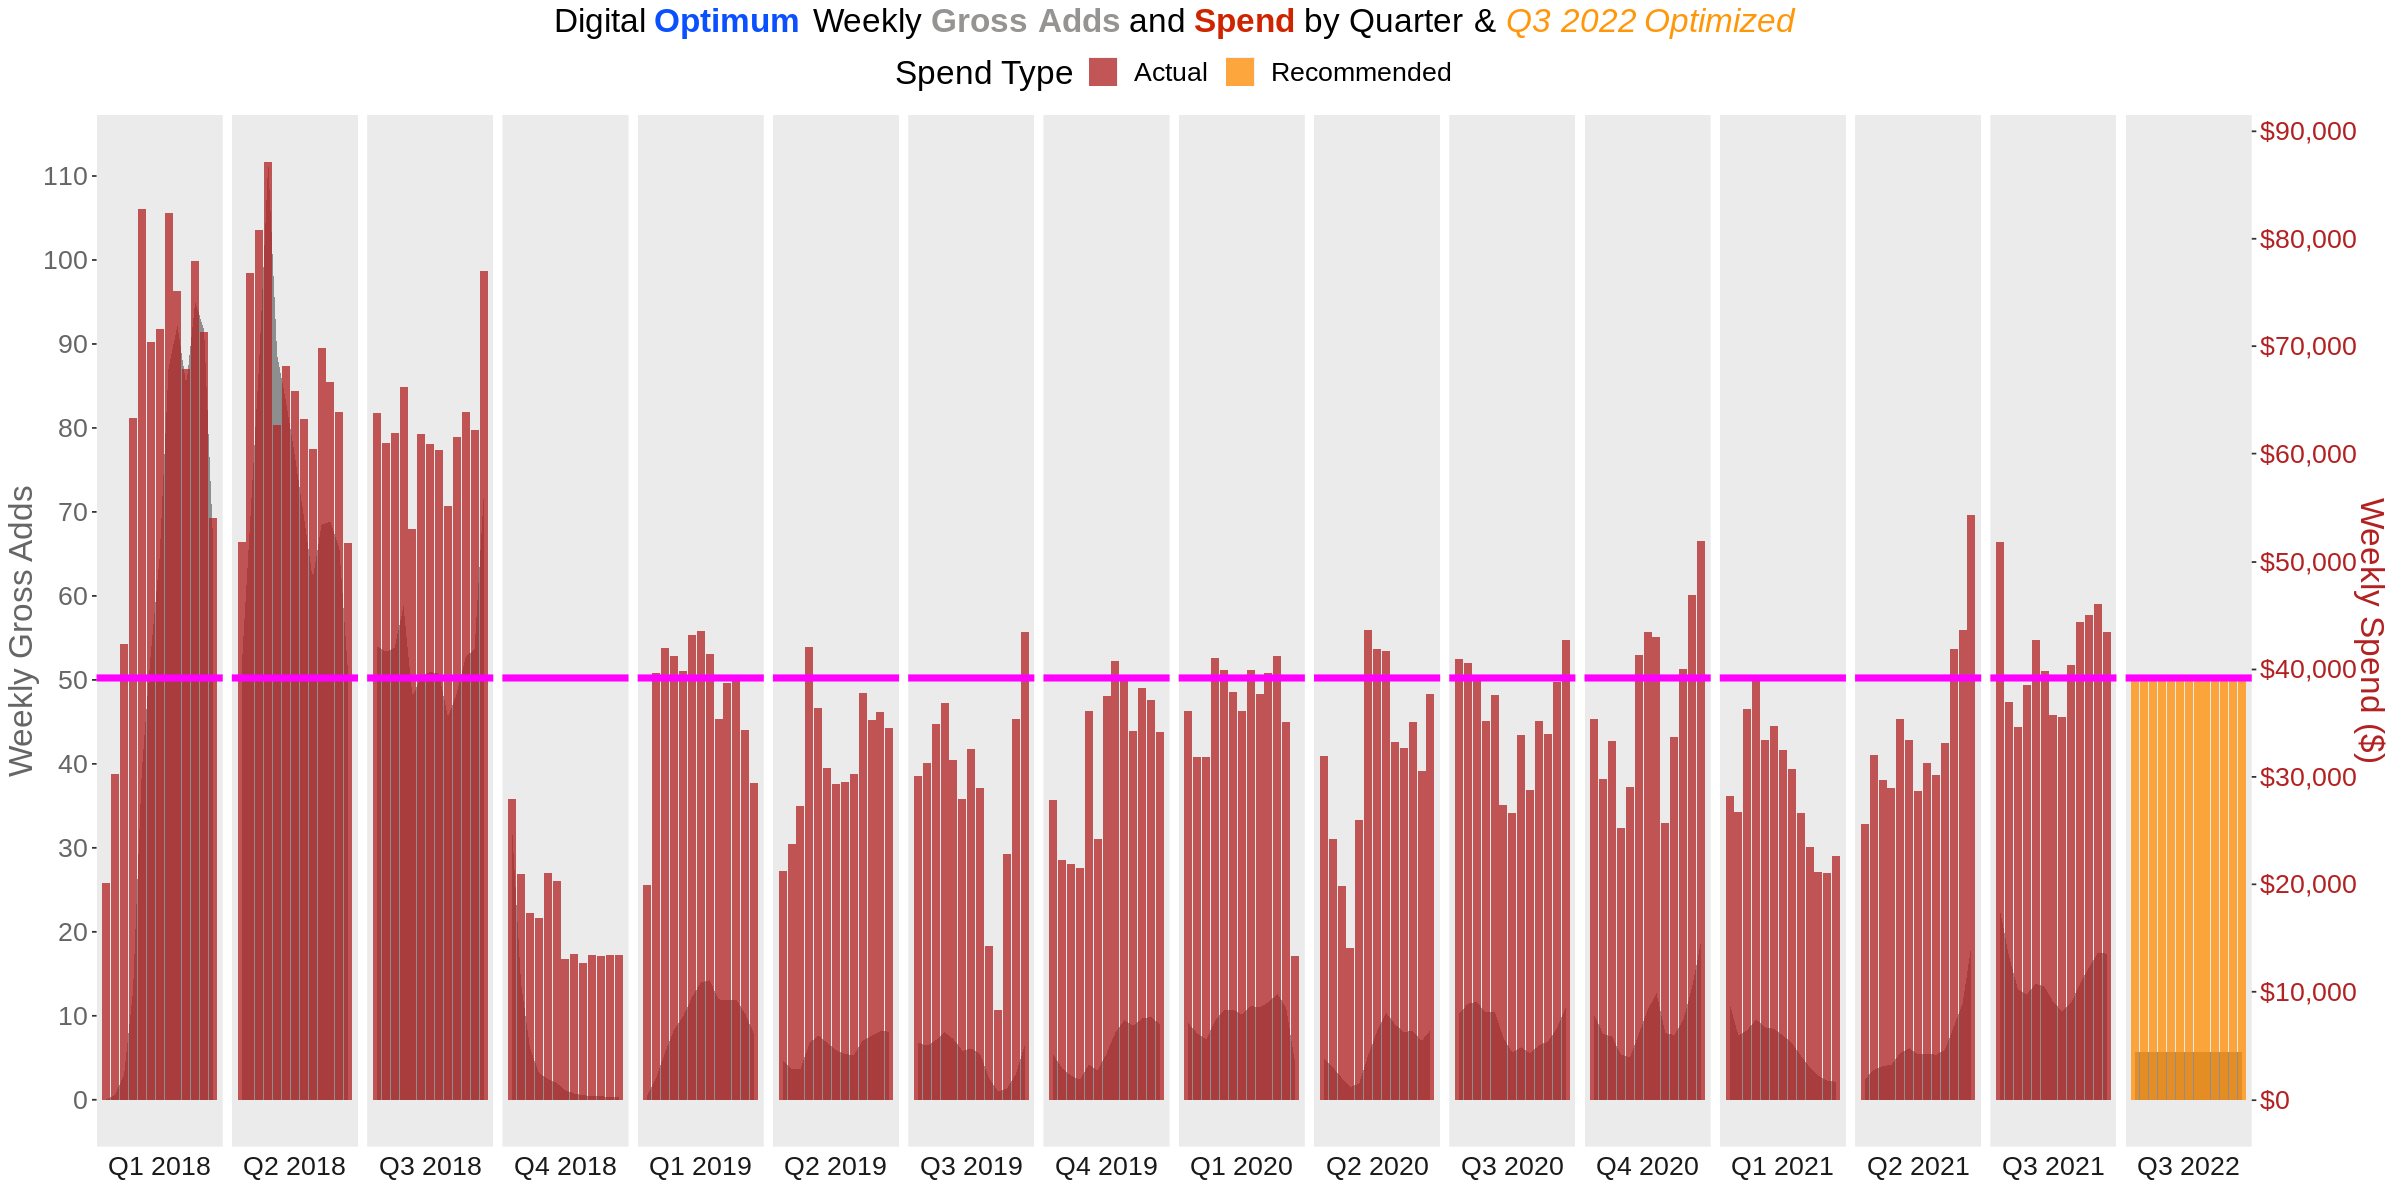

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


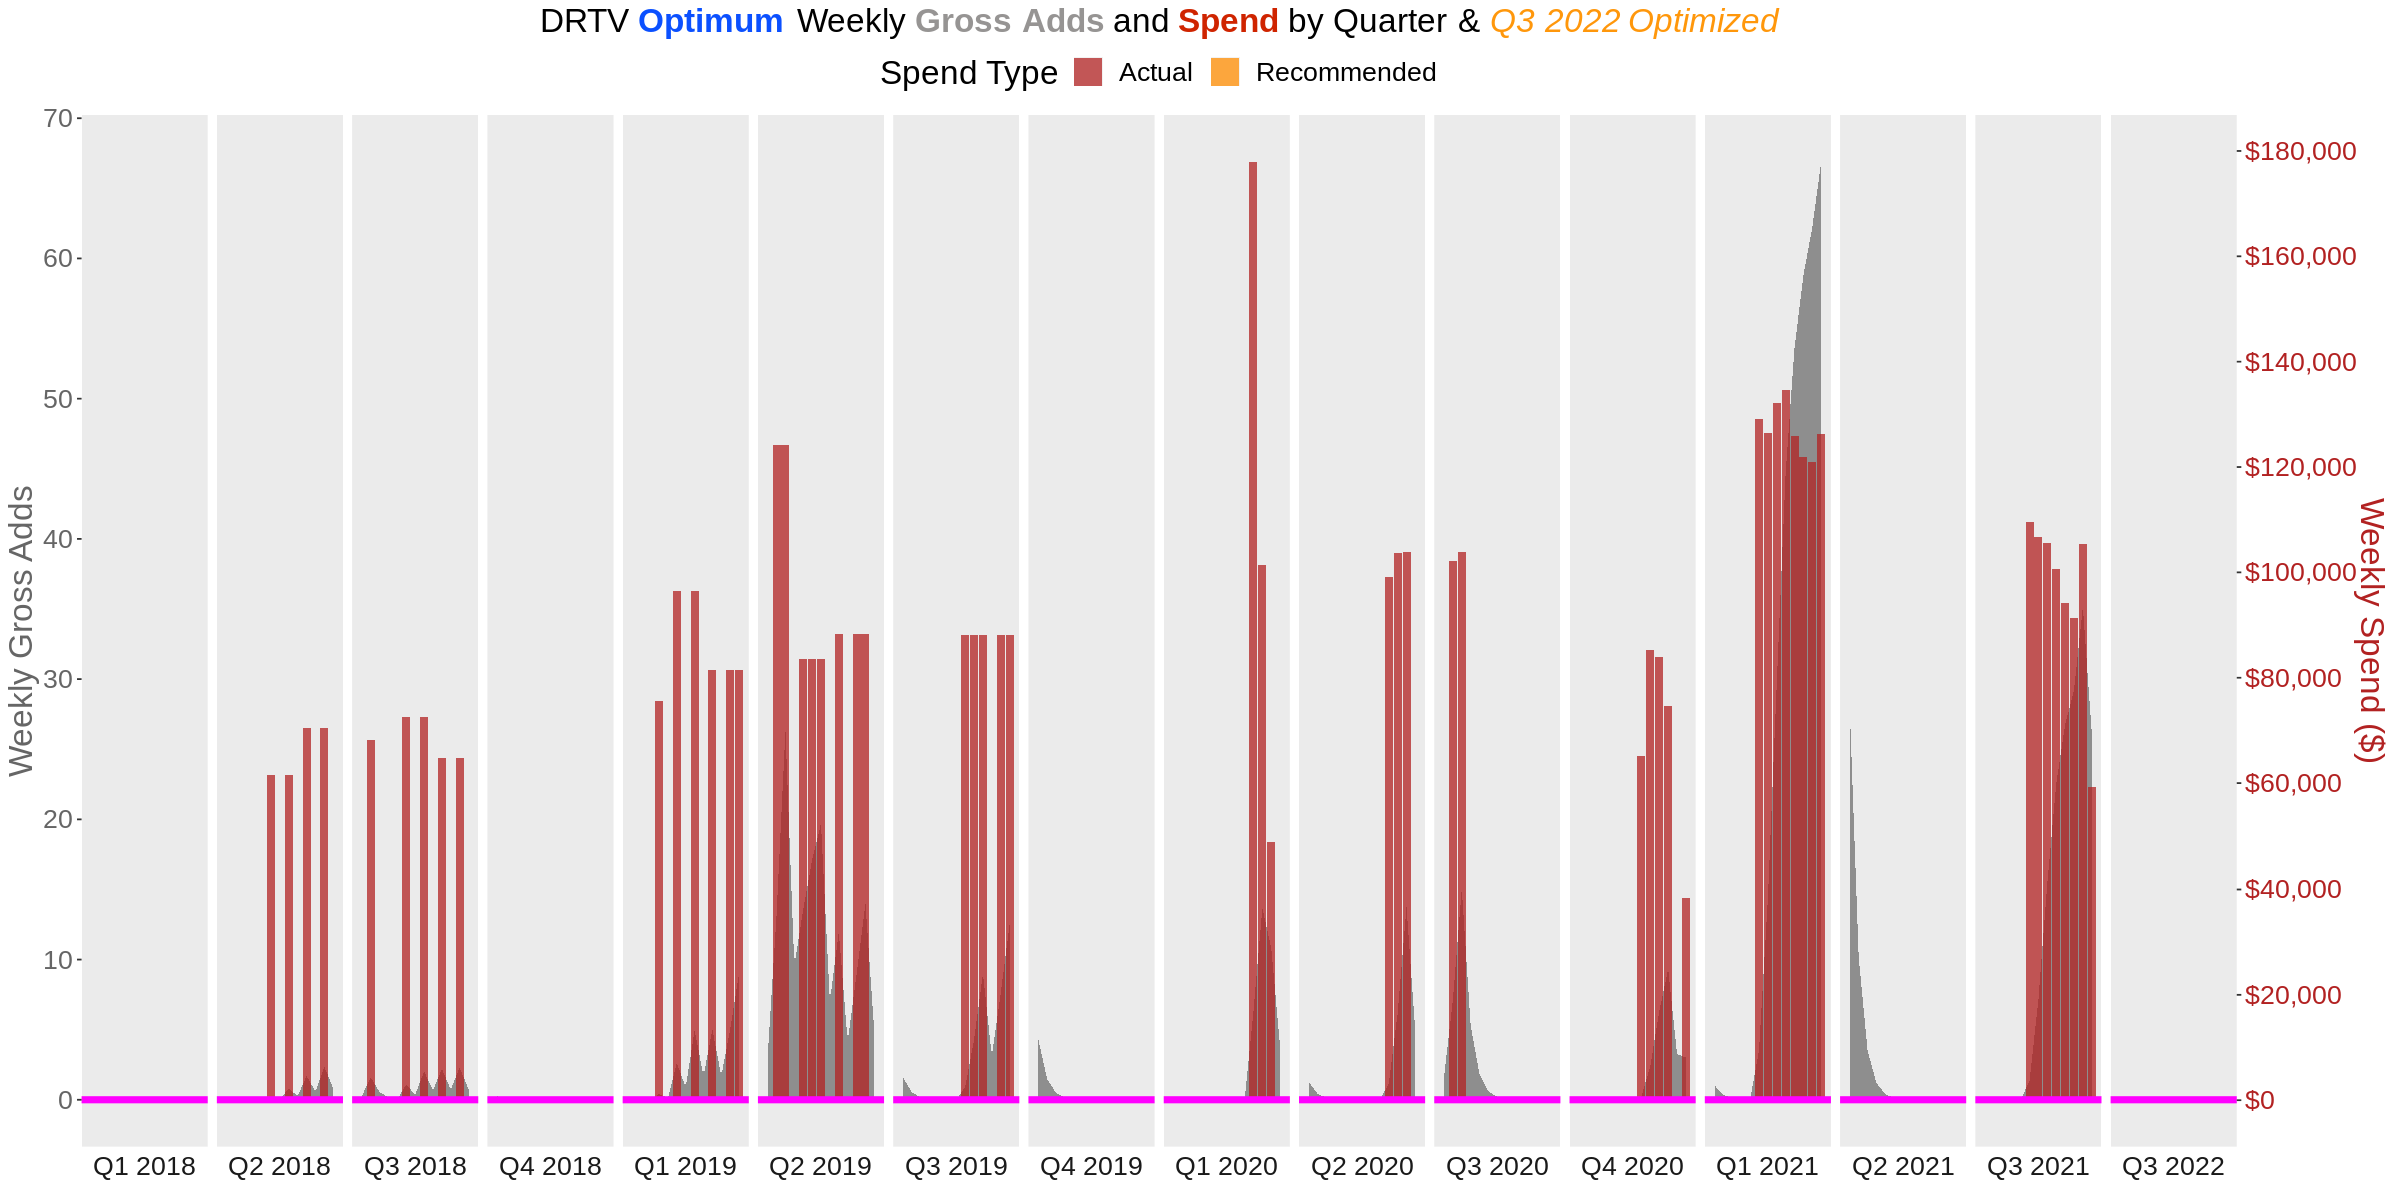

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


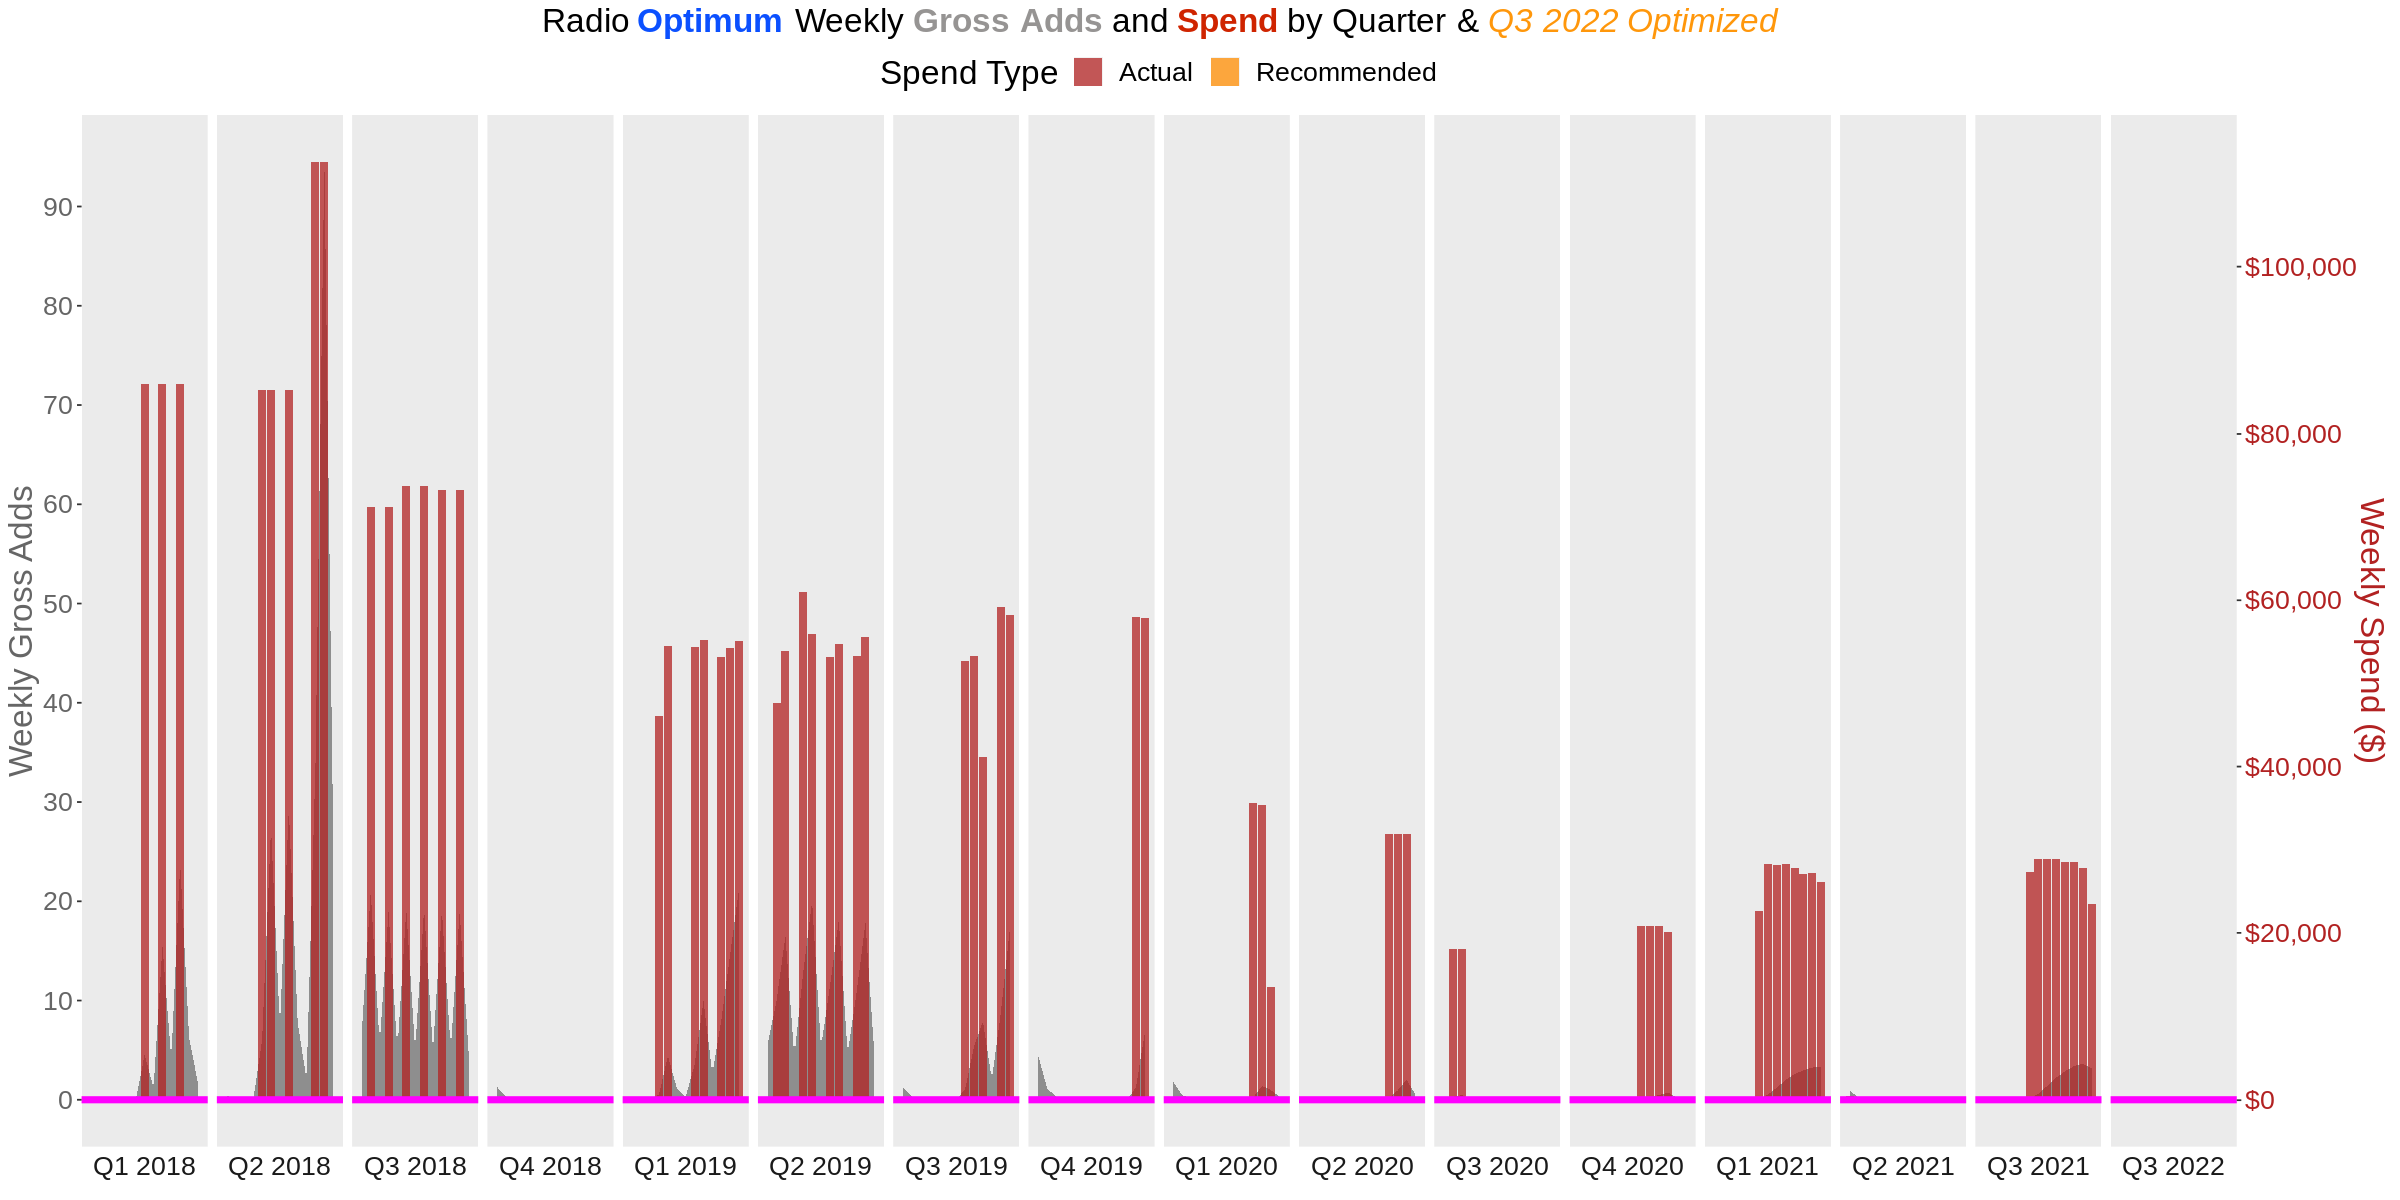

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


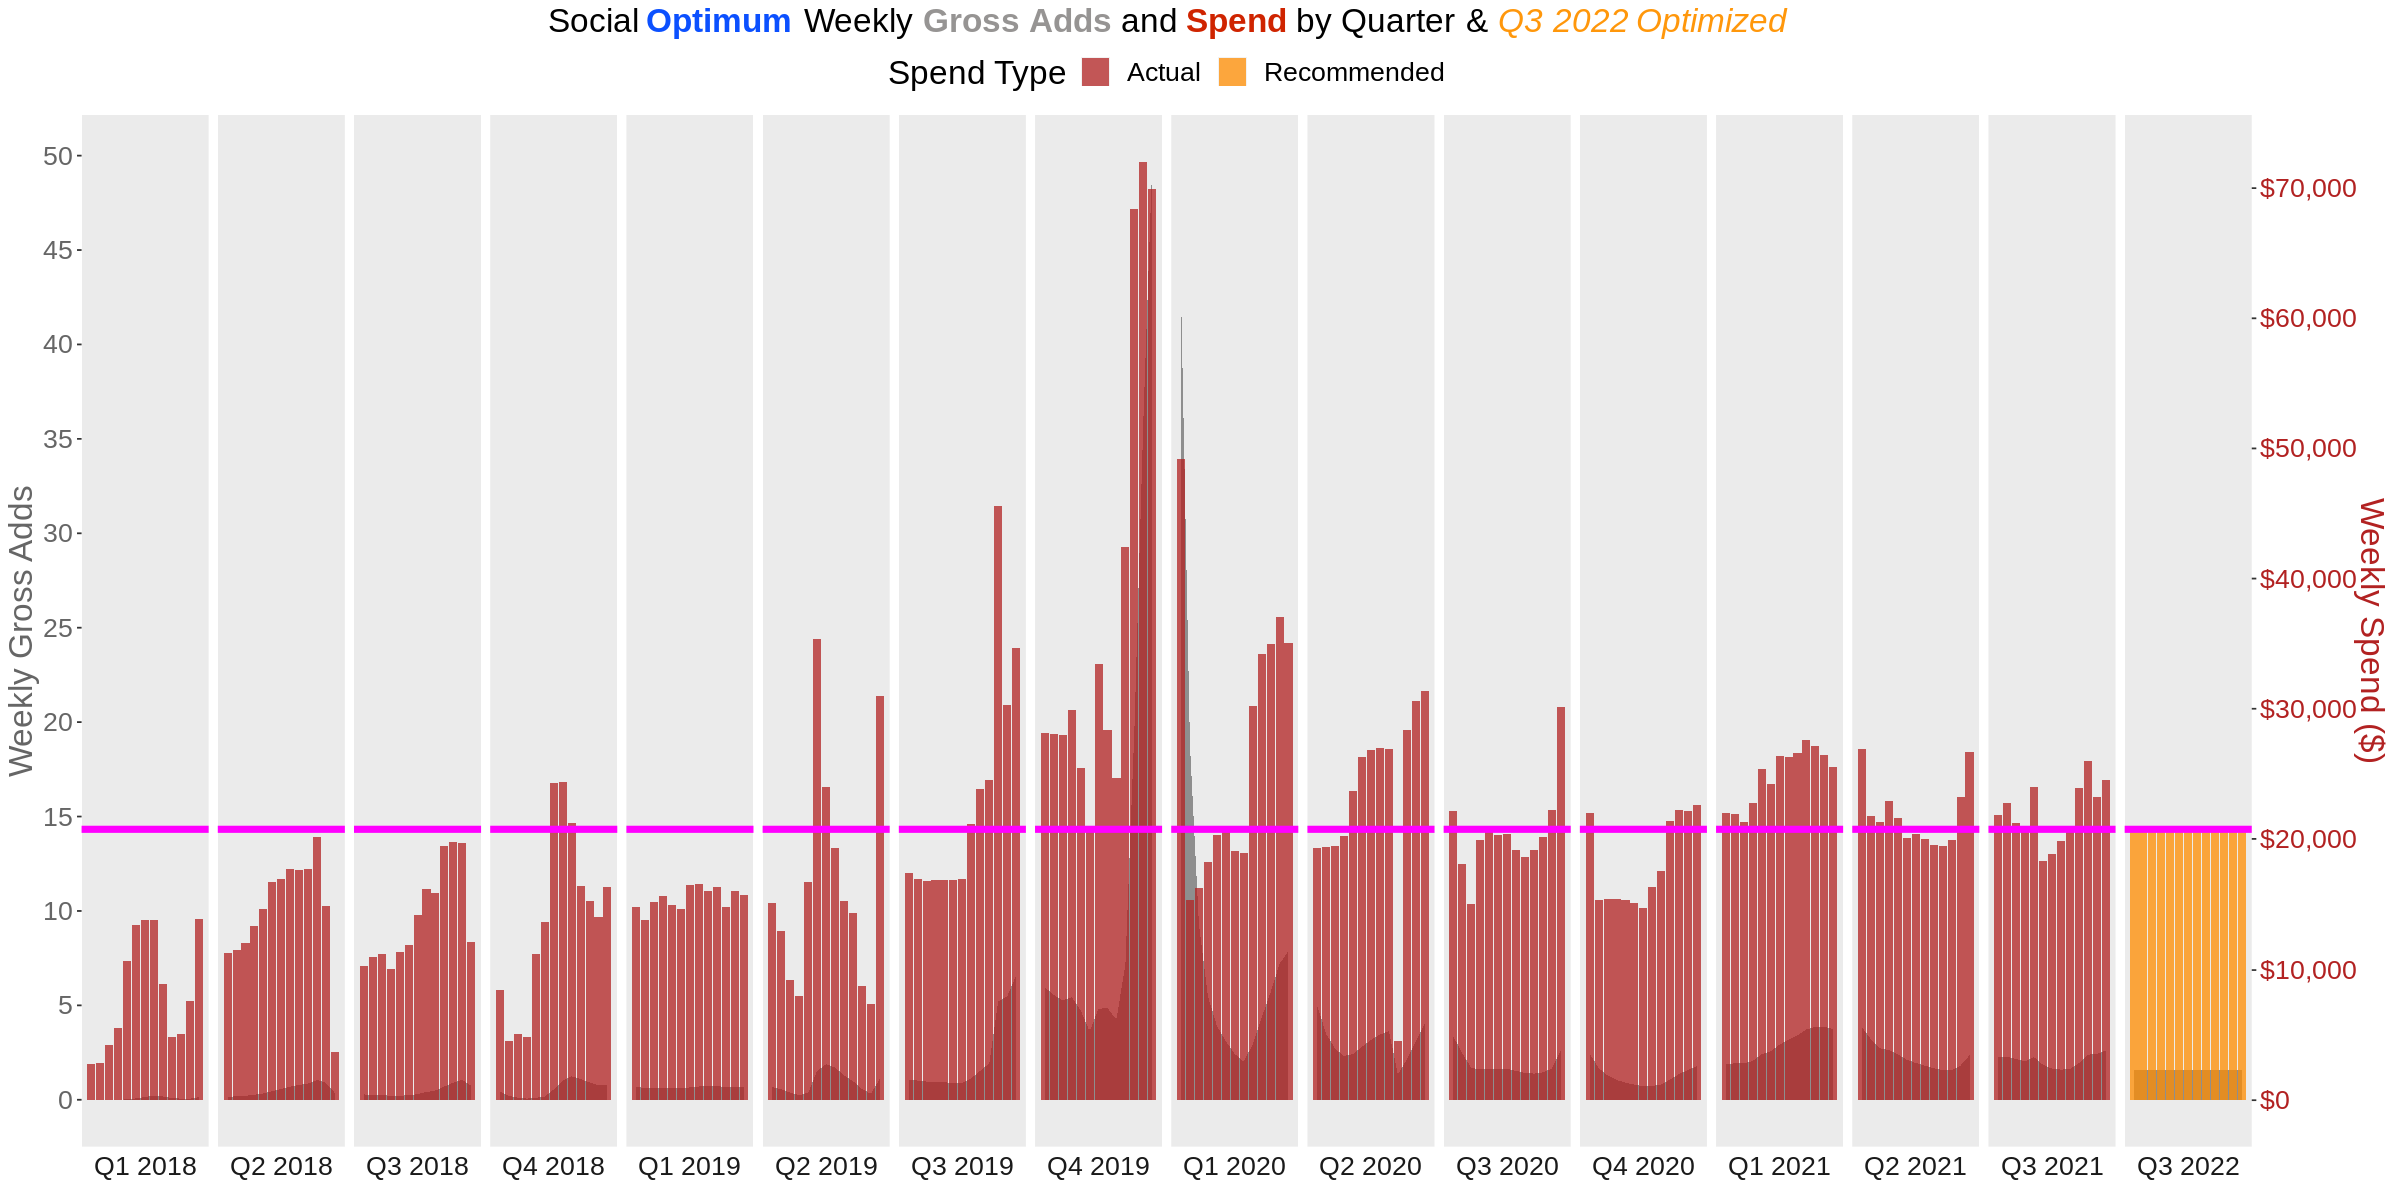

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


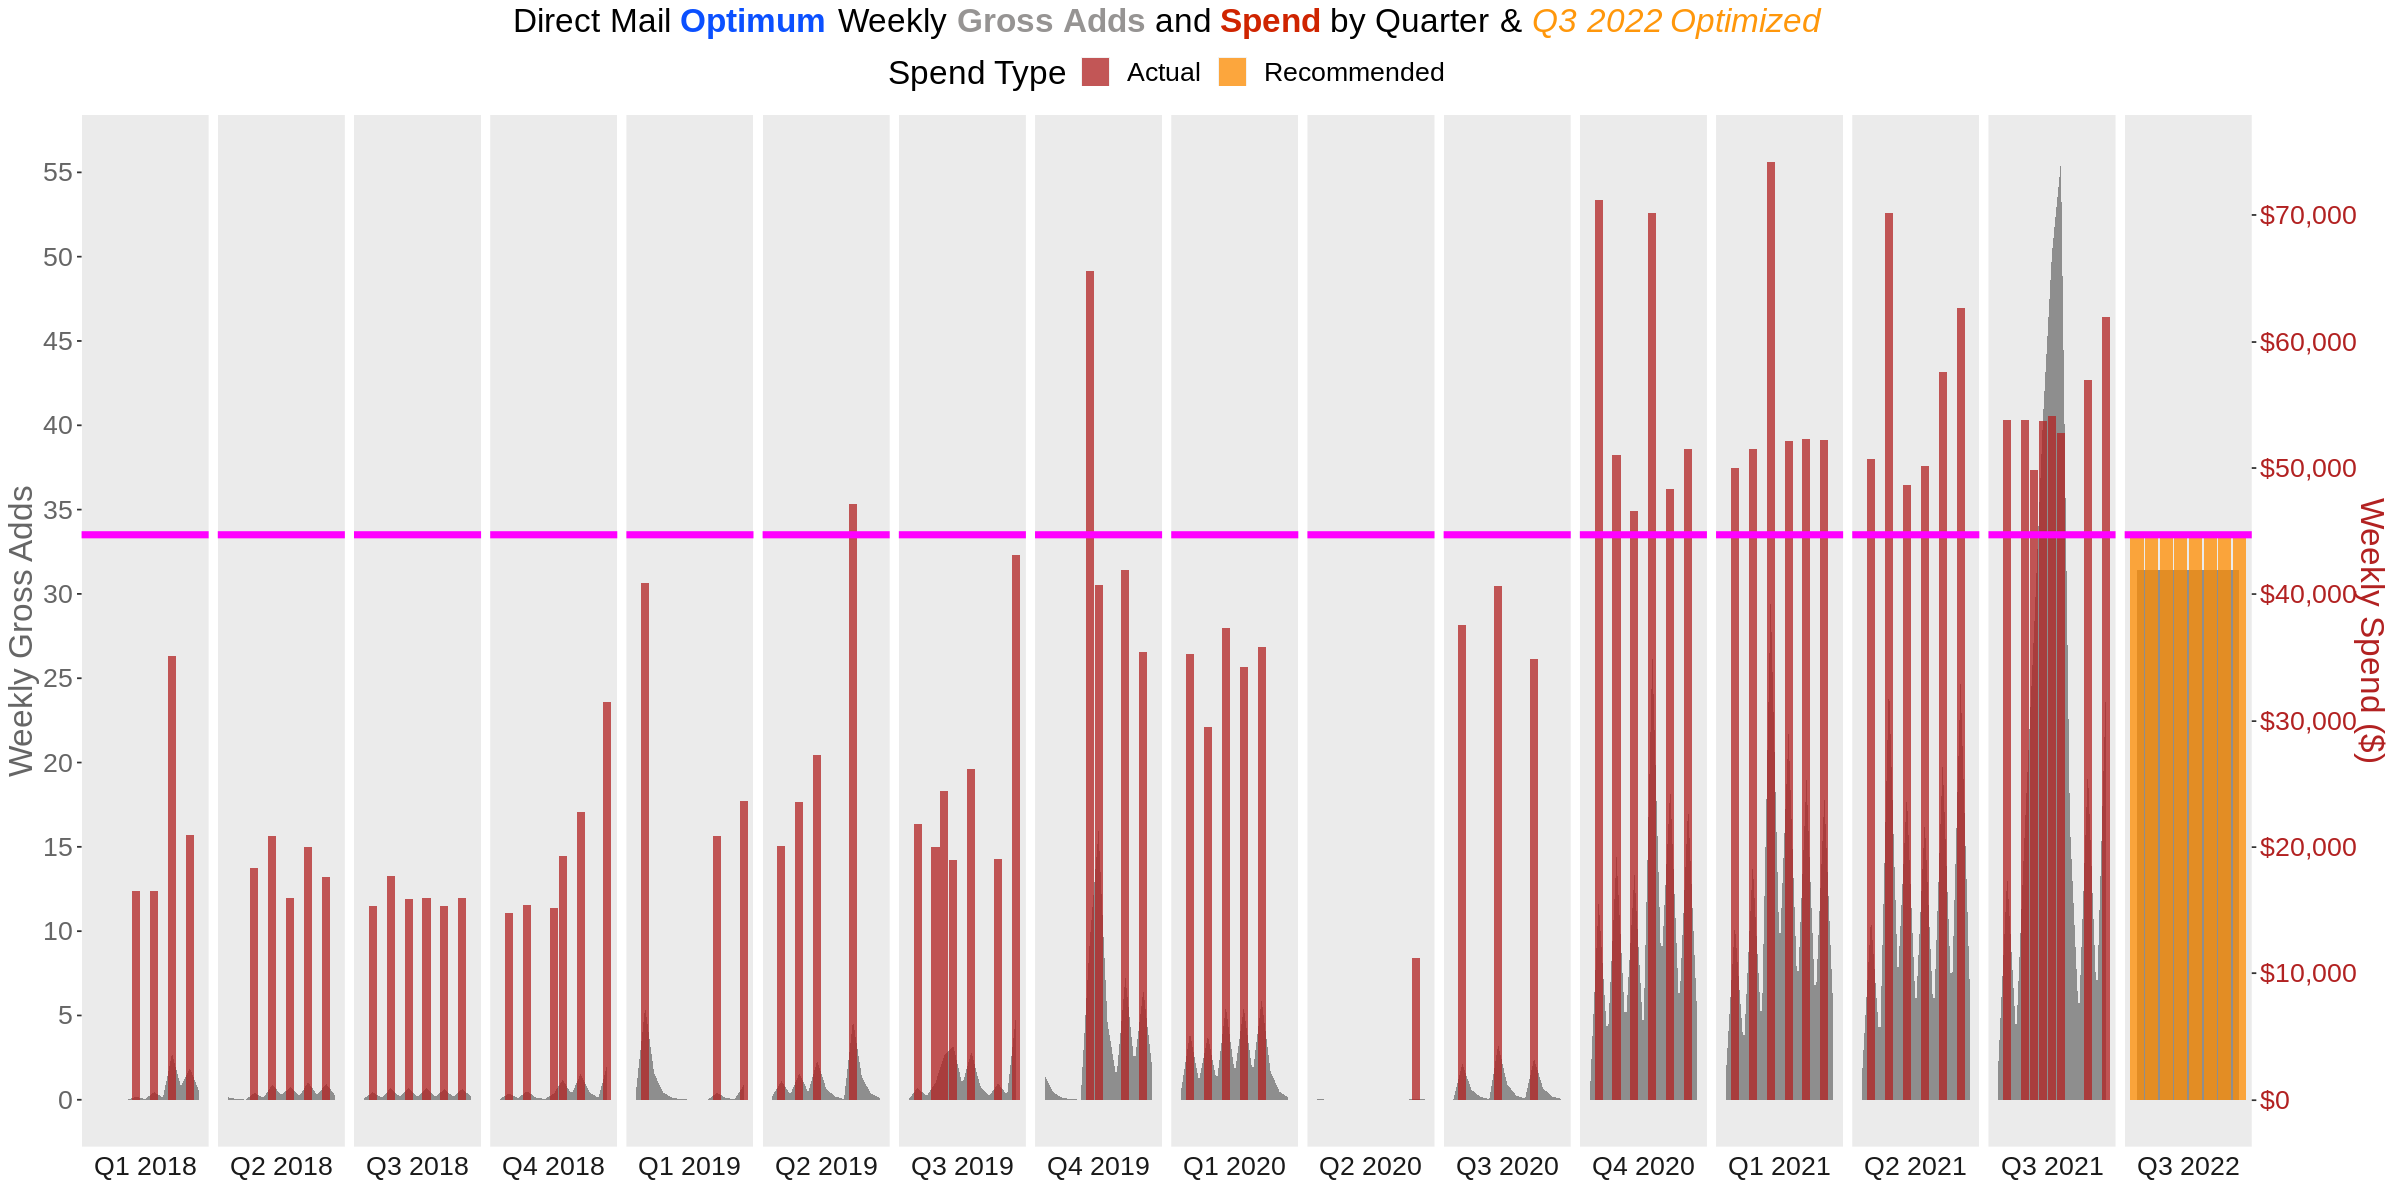

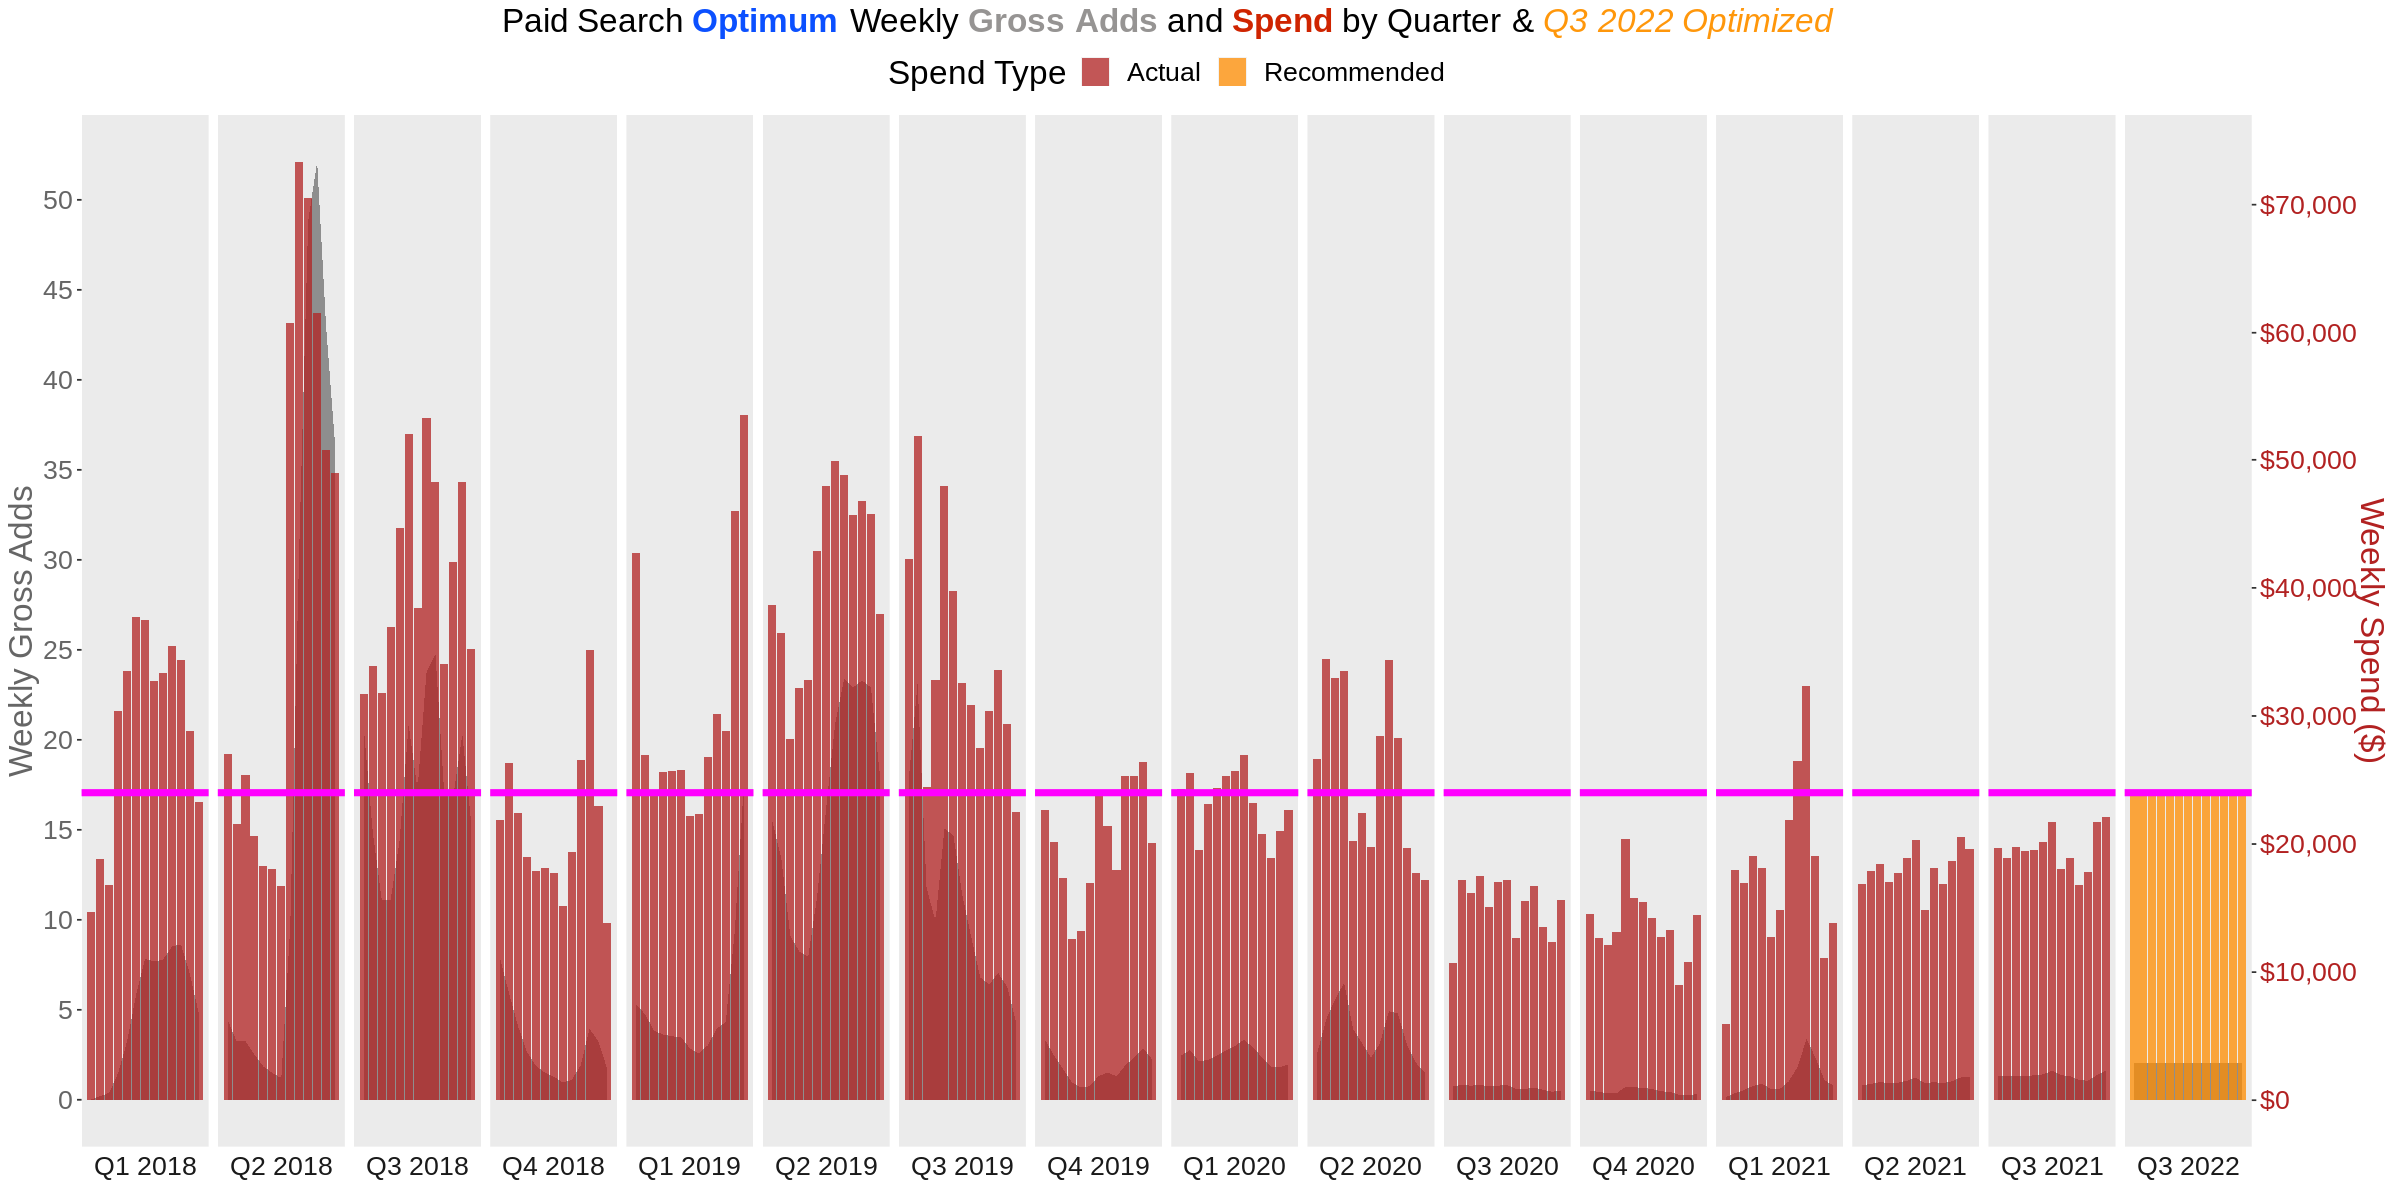

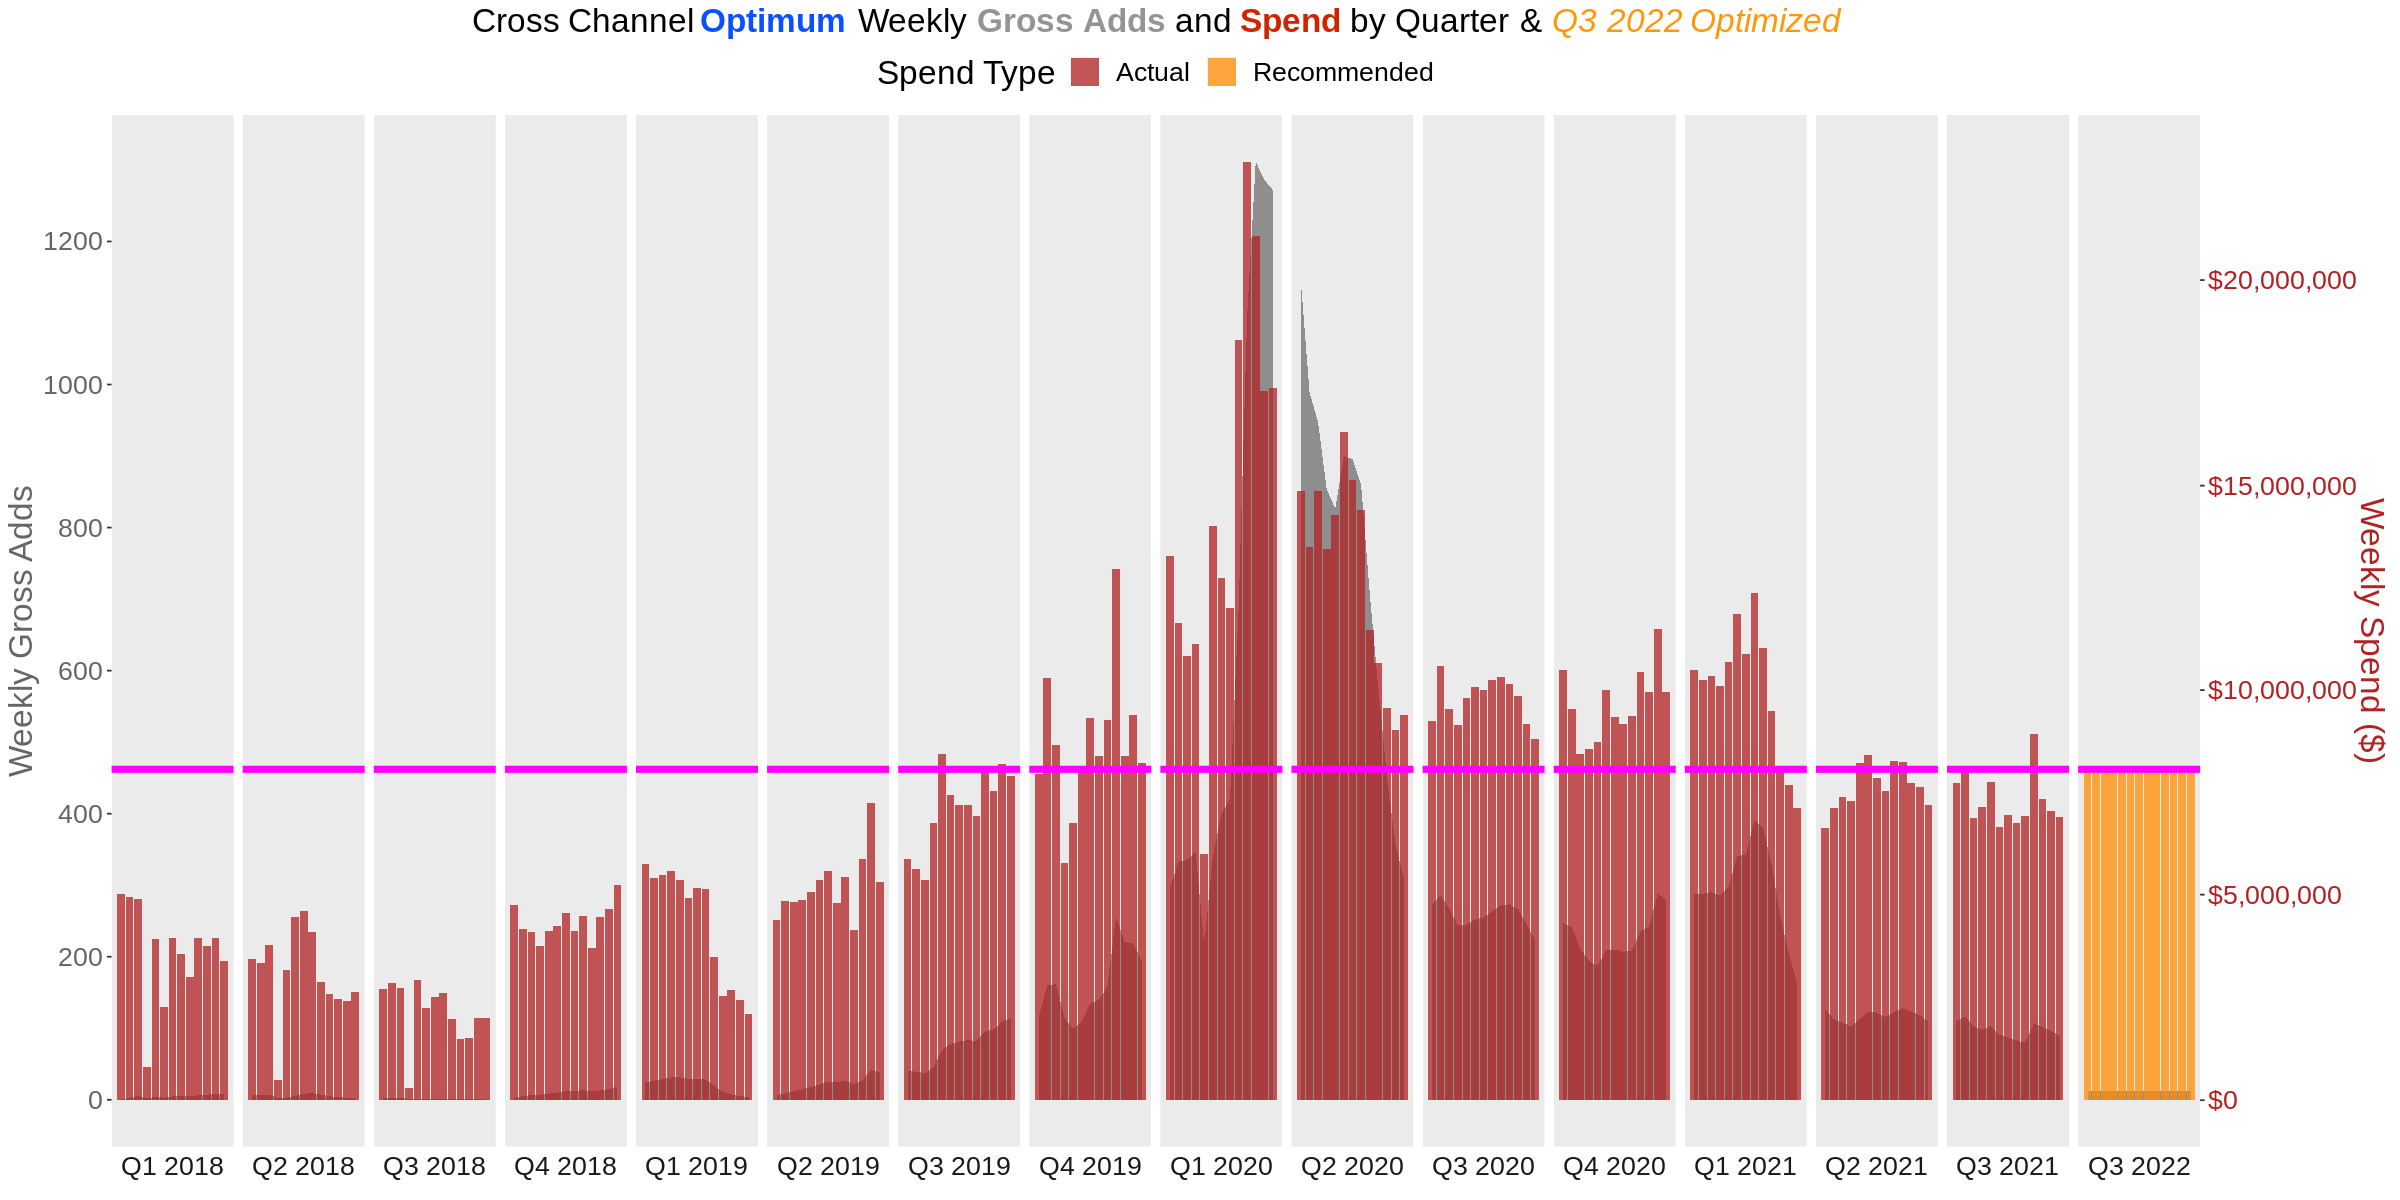

In [83]:
for(media in media_names_vec){
    media_df <- media_spend_target_all %>%
           select(period,dma,matches(media),brand,Spend_Type,Index,qy) %>%
           group_by(Index,period,brand,Spend_Type,qy) %>%
           summarize_at(.vars = vars(-dma),.funs = ~sum(.,na.rm=T)) %>%
           arrange(brand,period,Spend_Type) %>%
           rename_all(.funs = function(x){gsub(paste0(media,'_'),'',x)})
    
    
    ##For the title formatting the spend in K notation and formatting the CPMTGA as well
    format_spend <- fprint_w_cpmtga %>%
                    filter(Media == media & brand == 'Optimum') %>%
                    mutate_at(.vars = vars(Spend),.funs = ~paste0('$',so_formatter(round(.)))) %>%
                    select(Spend) %>%
                    pull()
    
    format_cpmtga <- fprint_w_cpmtga %>%
                    filter(Media == media & brand == 'Optimum') %>%
                    mutate_at(.vars = vars(CPMTGA),.funs = ~format_money(.,0)) %>%
                    select(CPMTGA) %>%
                    pull()
    
    format_target <- fprint_w_cpmtga %>%
                      filter(Media == media & brand == 'Optimum') %>%
                    mutate_at(.vars = vars(ga),.funs = ~format(round(.),big.mark = ',')) %>%
                    select(ga) %>%
                    pull()
    
    ##Fprint dataframe
    media_df_optimum <- media_df %>%
                   ungroup() %>%
                   filter(brand == 'Optimum') %>%
                   select(-brand) %>%
                   mutate(qy = factor(qy,levels = qy_vec))
    
     if(media%in%flight_media_vec){
        n_flight_weeks <- nbr_flight_weeks_opt
        readjust_flight_df <- media_df_optimum %>%
                   filter(Spend_Type == 'Recommended') %>%
                   head(n_flight_weeks) 
    
        
        media_df_optimum <- media_df_optimum %>%
                   filter(Spend_Type!='Recommended') %>%
                   bind_rows(readjust_flight_df)
    }
    options(repr.plot.width=20, repr.plot.height = 10) 

    
    scaling_fac <- max(media_df_optimum$Spend)/max(media_df_optimum$ga)
    
    media_plot <- media_df_optimum %>%
ggplot(.,aes(x=period)) +
geom_area(aes(y = ga),alpha = 0.5) +
geom_col(aes(y=Spend/scaling_fac,fill = Spend_Type),size = 0.25,alpha = 0.75) +
scale_fill_manual(name = "Spend Type",values=c("firebrick", "darkorange")) +
scale_y_continuous(
    
    # Features of the first axis
    name = "Weekly Gross Adds",
    
    # Add a second axis and specify its features
    sec.axis = sec_axis(~.*scaling_fac, name="Weekly Spend ($)",breaks=scales::breaks_pretty(7),labels=scales::dollar_format()),
    breaks = scales::breaks_pretty(10)
  ) +
#geom_hline(aes(yintercept=LB/scaling_fac),color = 'yellow',size =  2) +
#geom_hline(aes(yintercept=UB/scaling_fac),color = 'yellow',size = 2) +
geom_hline(aes(yintercept=optim/scaling_fac),color = 'magenta',size = 2) +
    
scale_x_date(breaks = scales::breaks_pretty(10)) +
#scale_fill_discrete(name = "Spend Type") +
labs(#title = sprintf("<b style='color:#F327DD'>%s</b>/<b style ='color:#969493'>%s GAs = </b><b style='color:#F327DD'>%s</b><b style='color:#969493'> per GA</b>",format_spend,format_target,format_cpmtga),
     subtitle = sprintf("%s <b style='color:#0B50FF'>Optimum</b> Weekly <b style ='color:#969493'>Gross Adds</b> and <b style='color:#CF2400'>Spend</b> by Quarter & <i style='color:#FF970B'>%s Optimized</i>",cleaned_names_list[media],quarter_2_optimize))+
theme_gray() +
theme(plot.title = element_markdown(lineheight = 1.5,size = 30),
      plot.subtitle = element_markdown(lineheight = 1.1,hjust = 0.5,size = 20),
      axis.title.x = element_blank(),
     text = element_text(size=20),
     legend.position = "top",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        #plot.background = element_rect(fill = "gray"),
        axis.title.y.right = element_text(color = 'firebrick'),
        axis.text.y.right = element_text(color = 'firebrick'),
        axis.title.y.left = element_text(color = 'gray40'),
        axis.text.y.left = element_text(color = 'gray40'),) +
    facet_grid(.~qy, scales = "free", switch = "x",labeller=quarter_labeller) + 
    theme(strip.placement = "inside",
          strip.background =element_rect(fill="white"))
    
    print(media_plot)
    ggsave(plot = media_plot,filename = paste0('Q32022_Simulated_8w_weekly/Optimum_',media,'.png'),width = 20,height = 10)
    
}

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”
Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”
Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


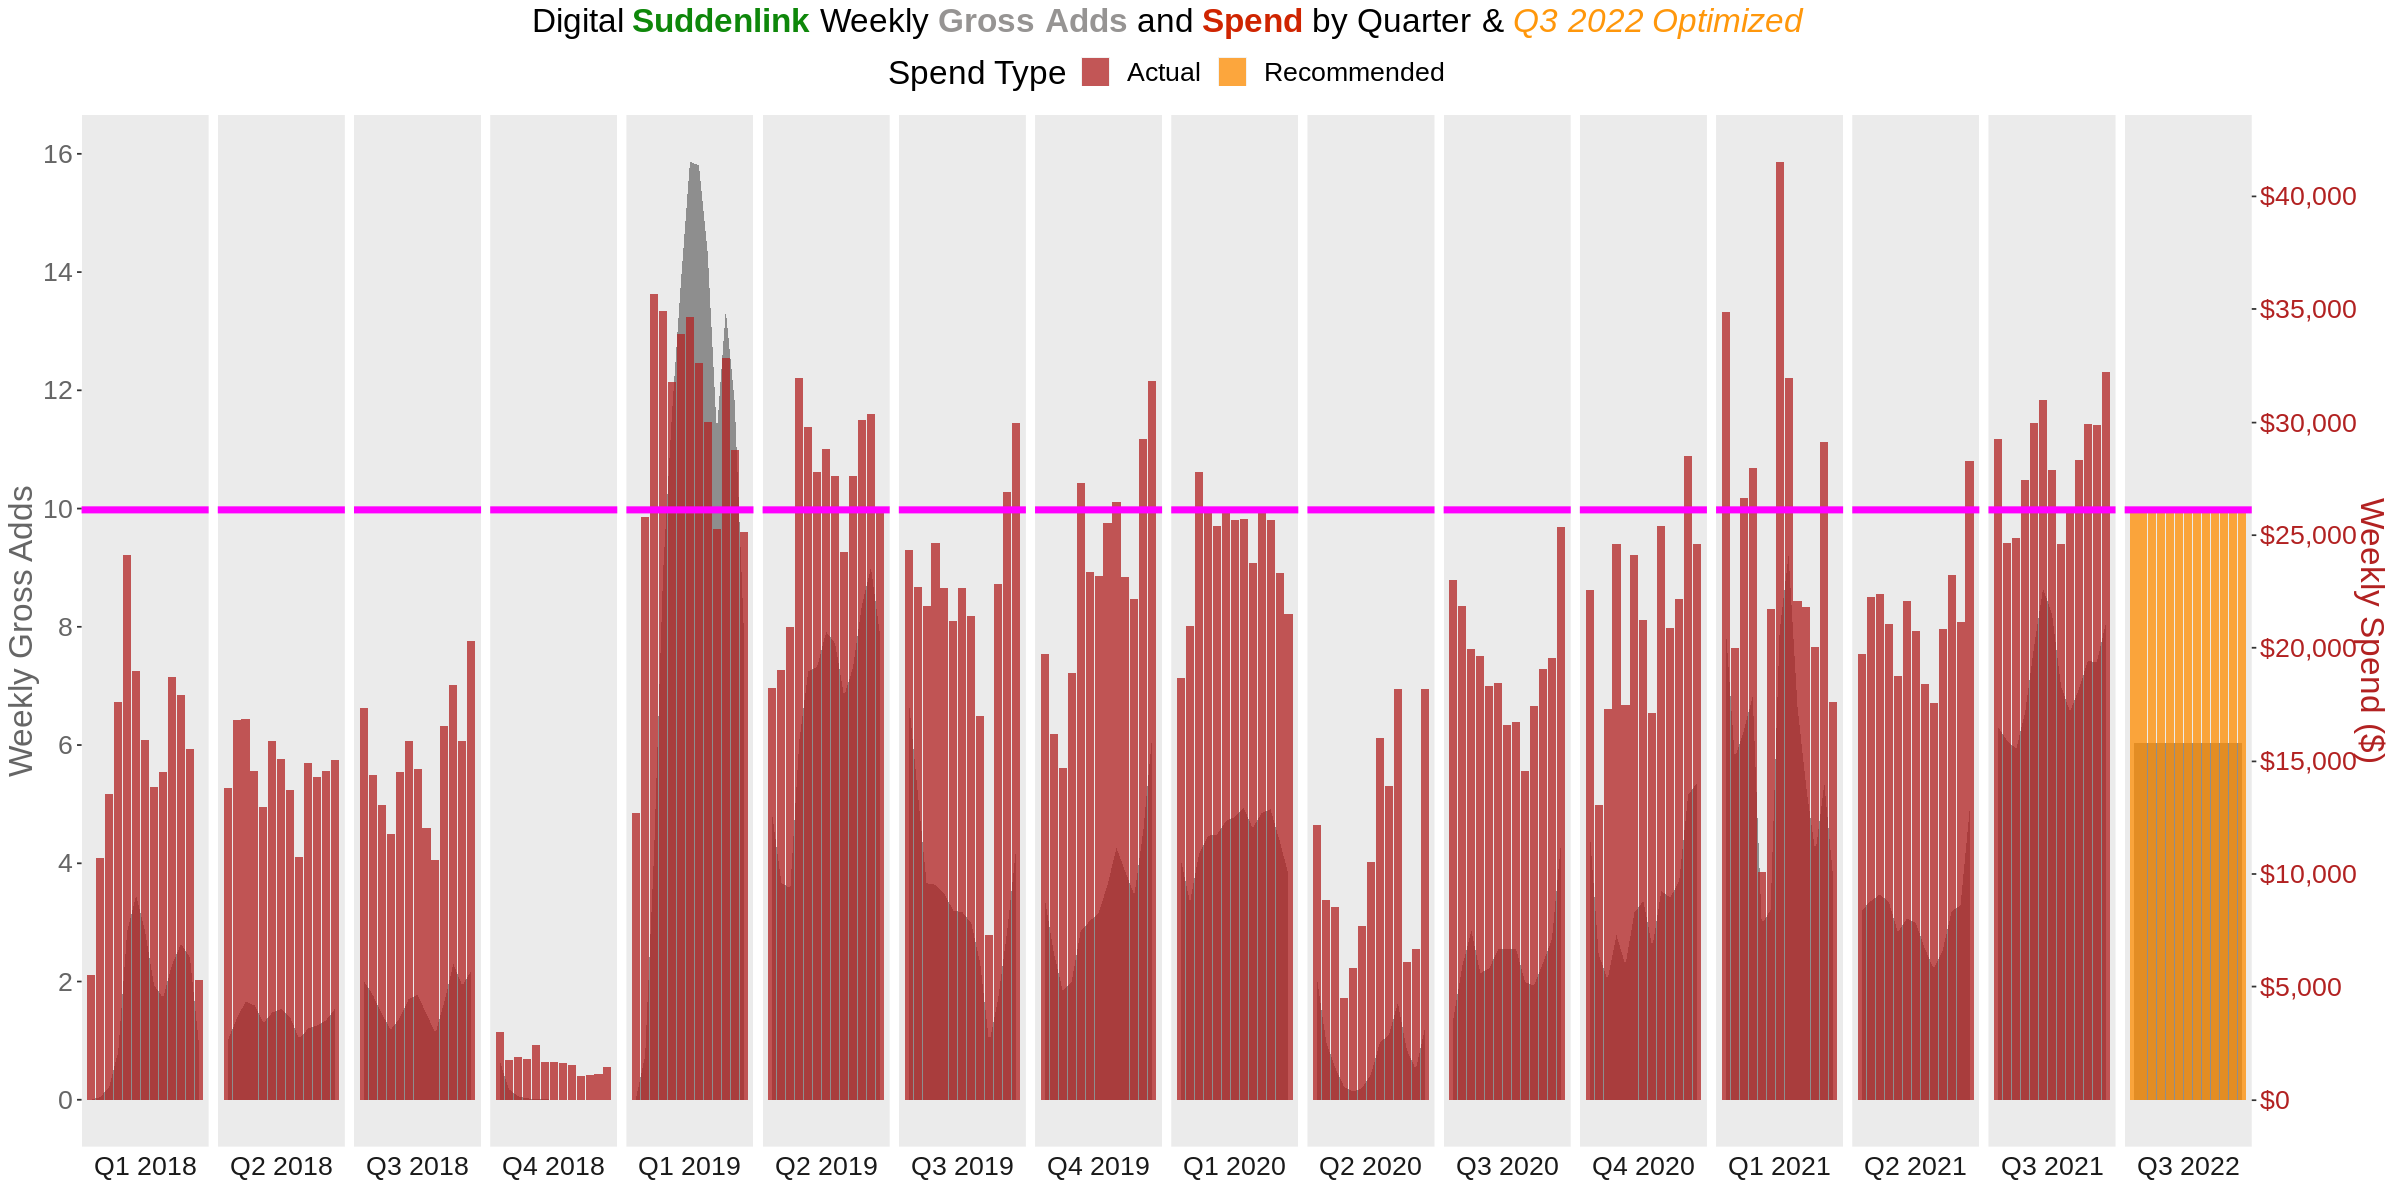

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


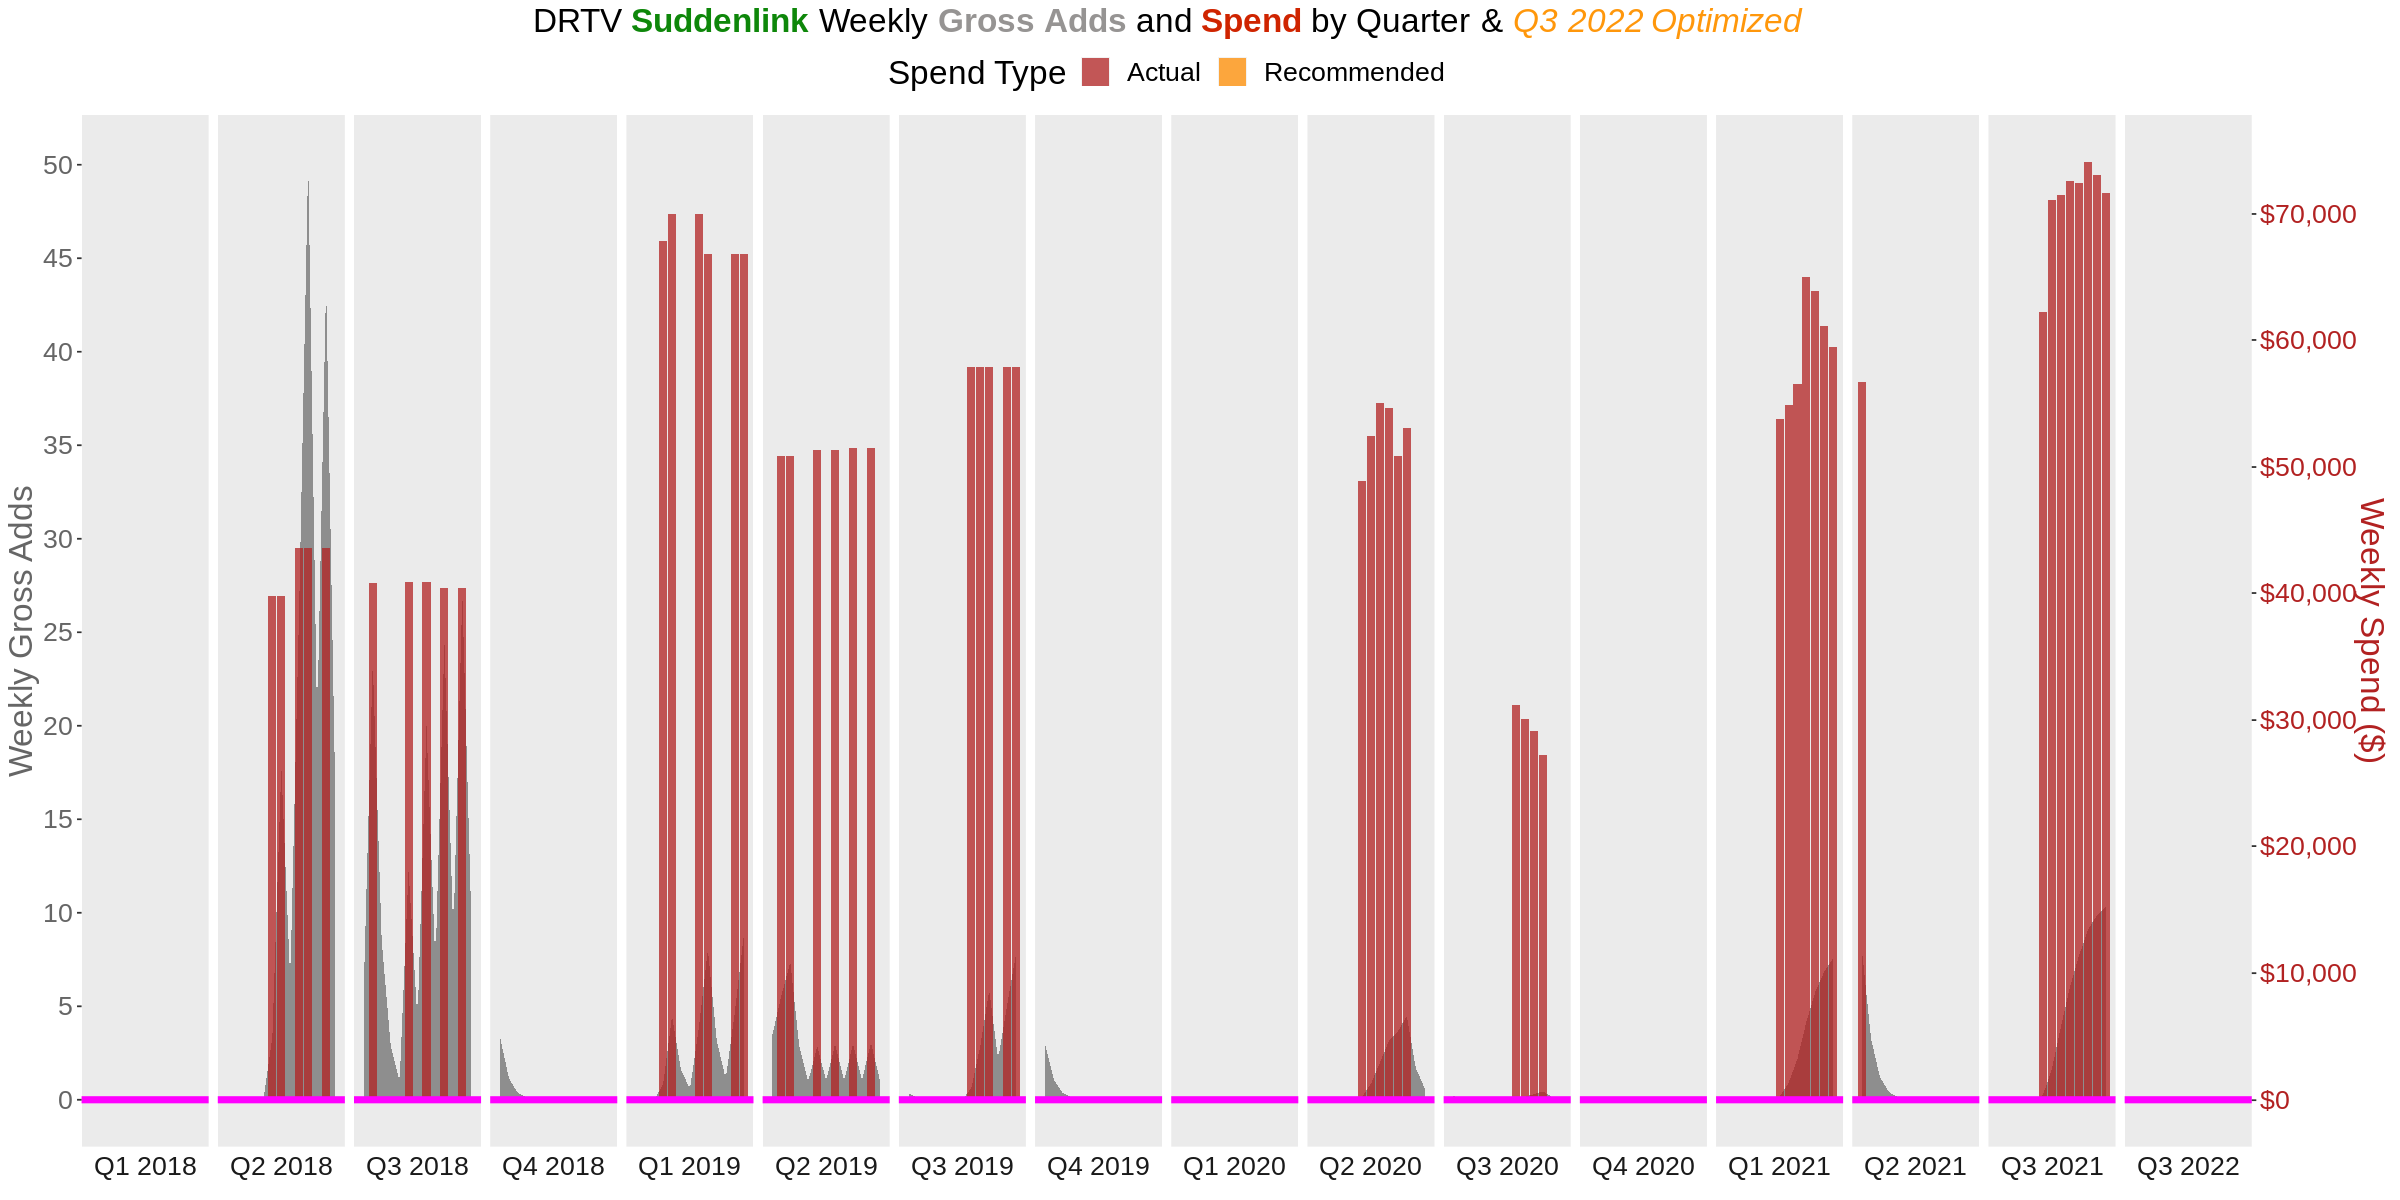

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


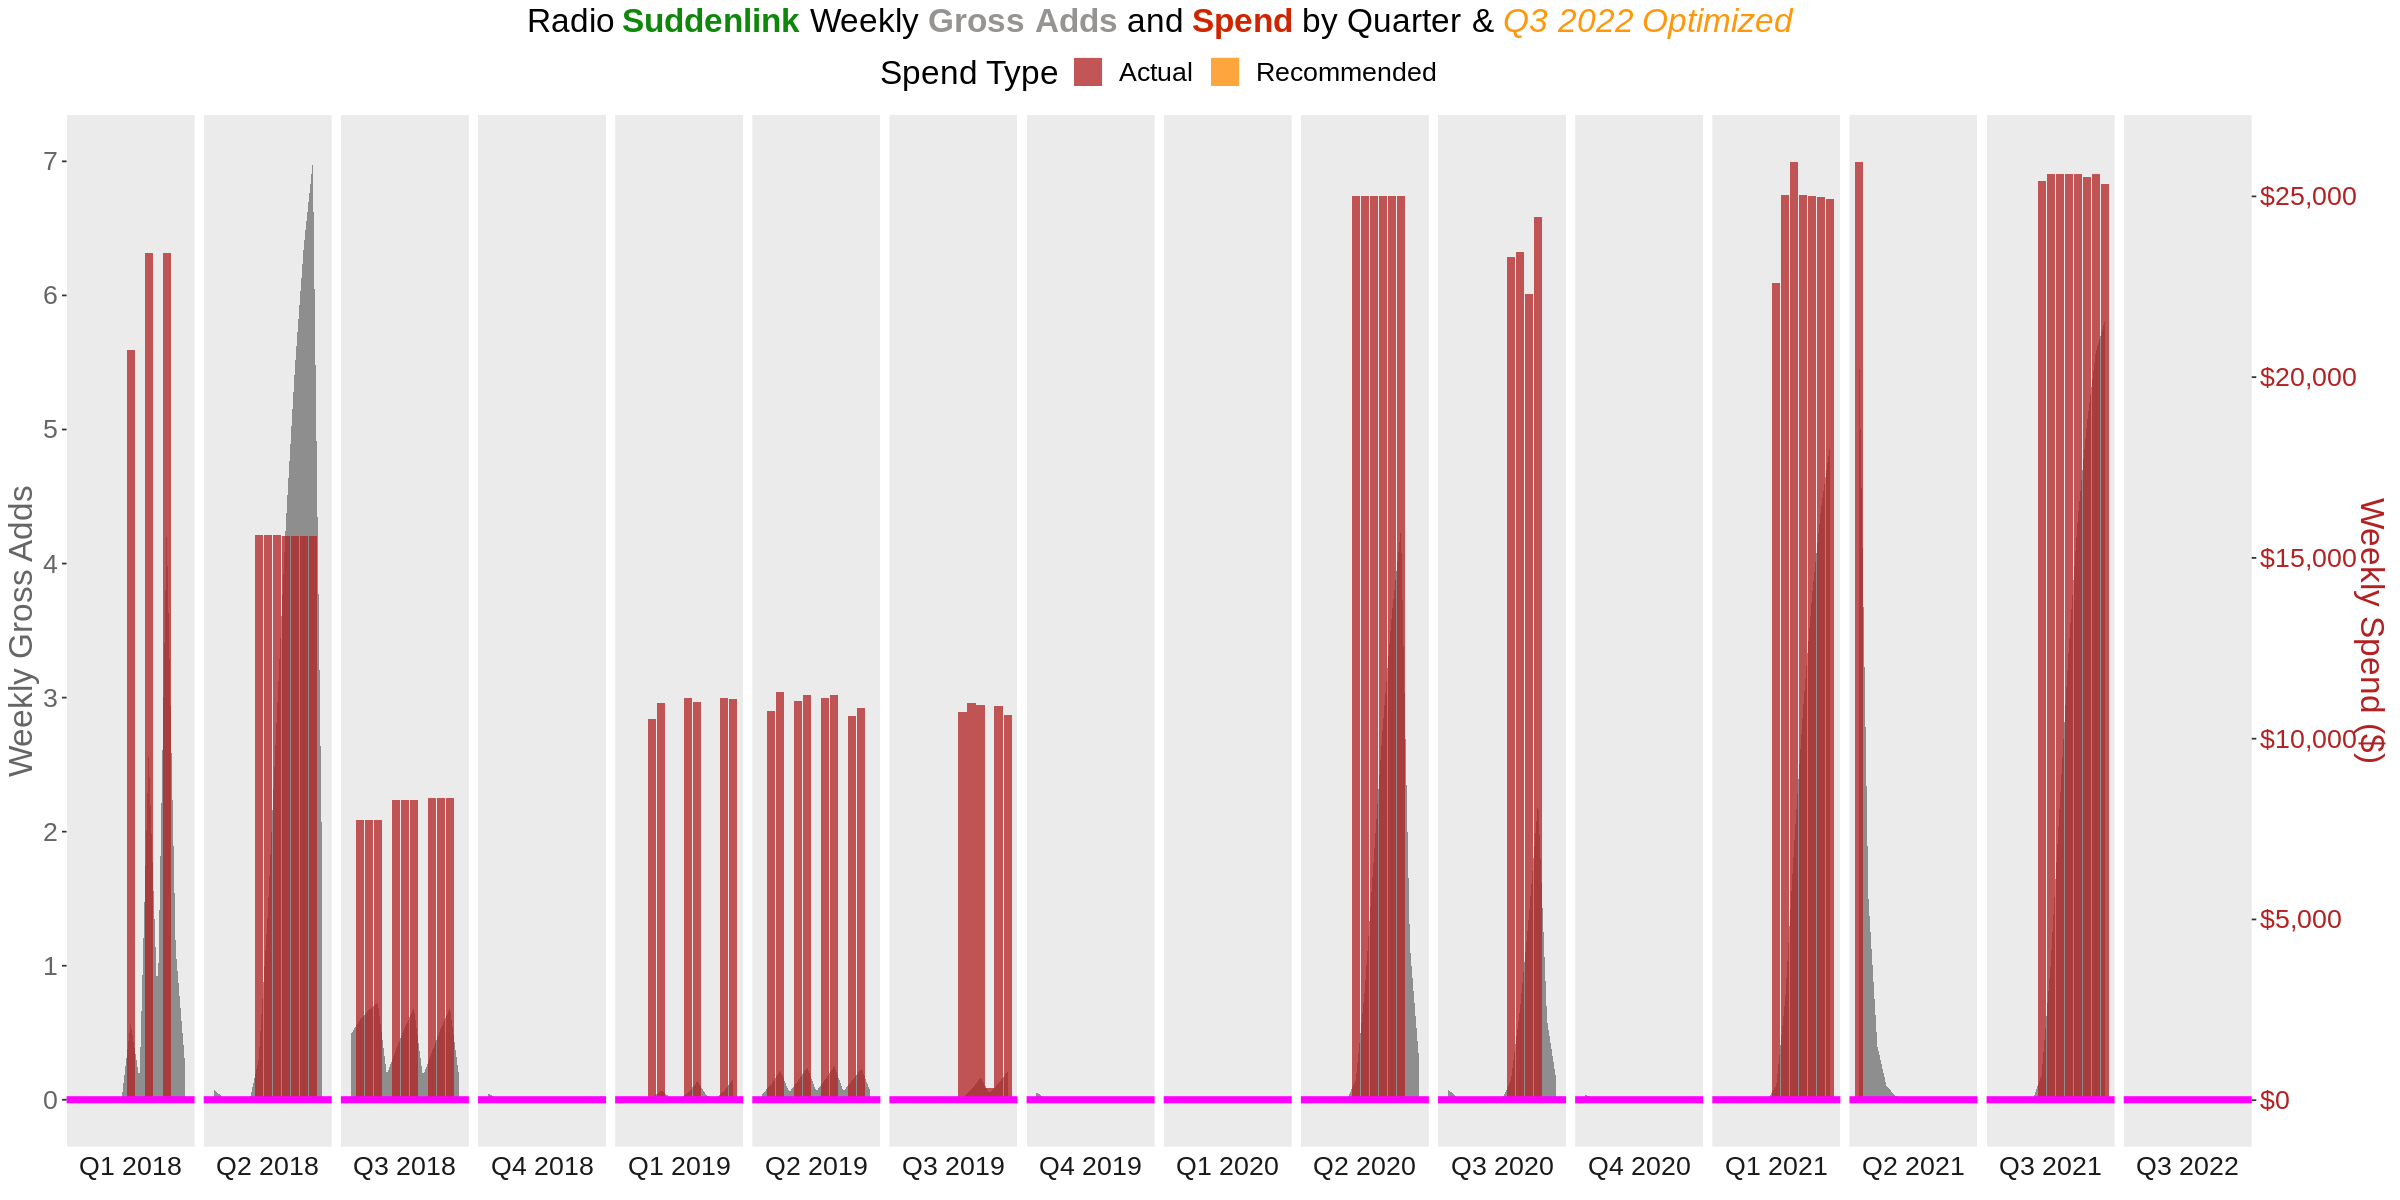

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


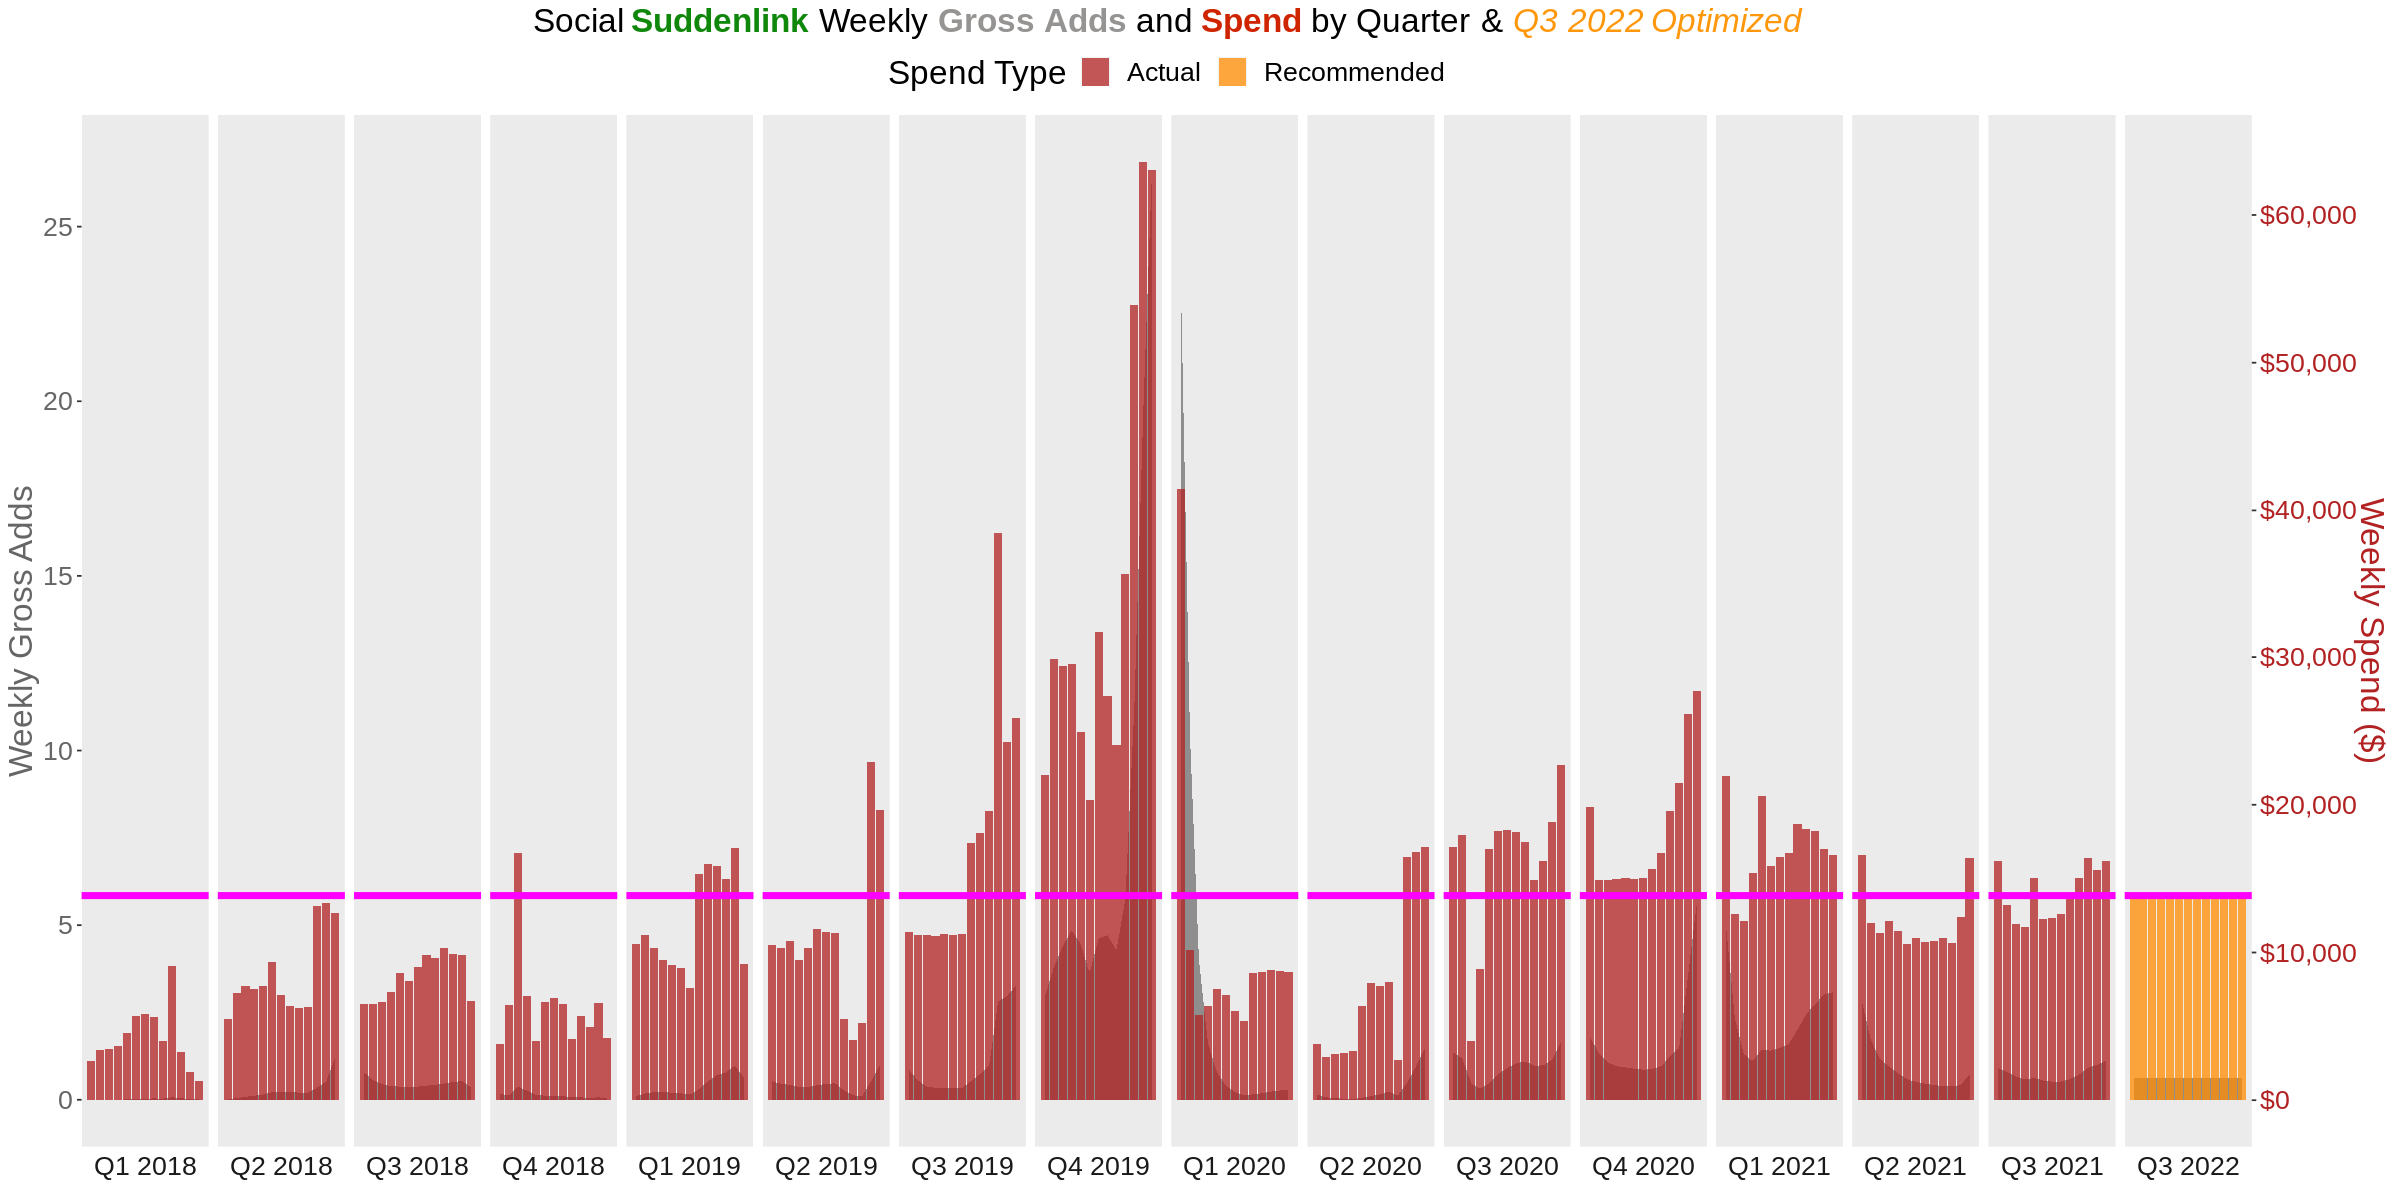

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


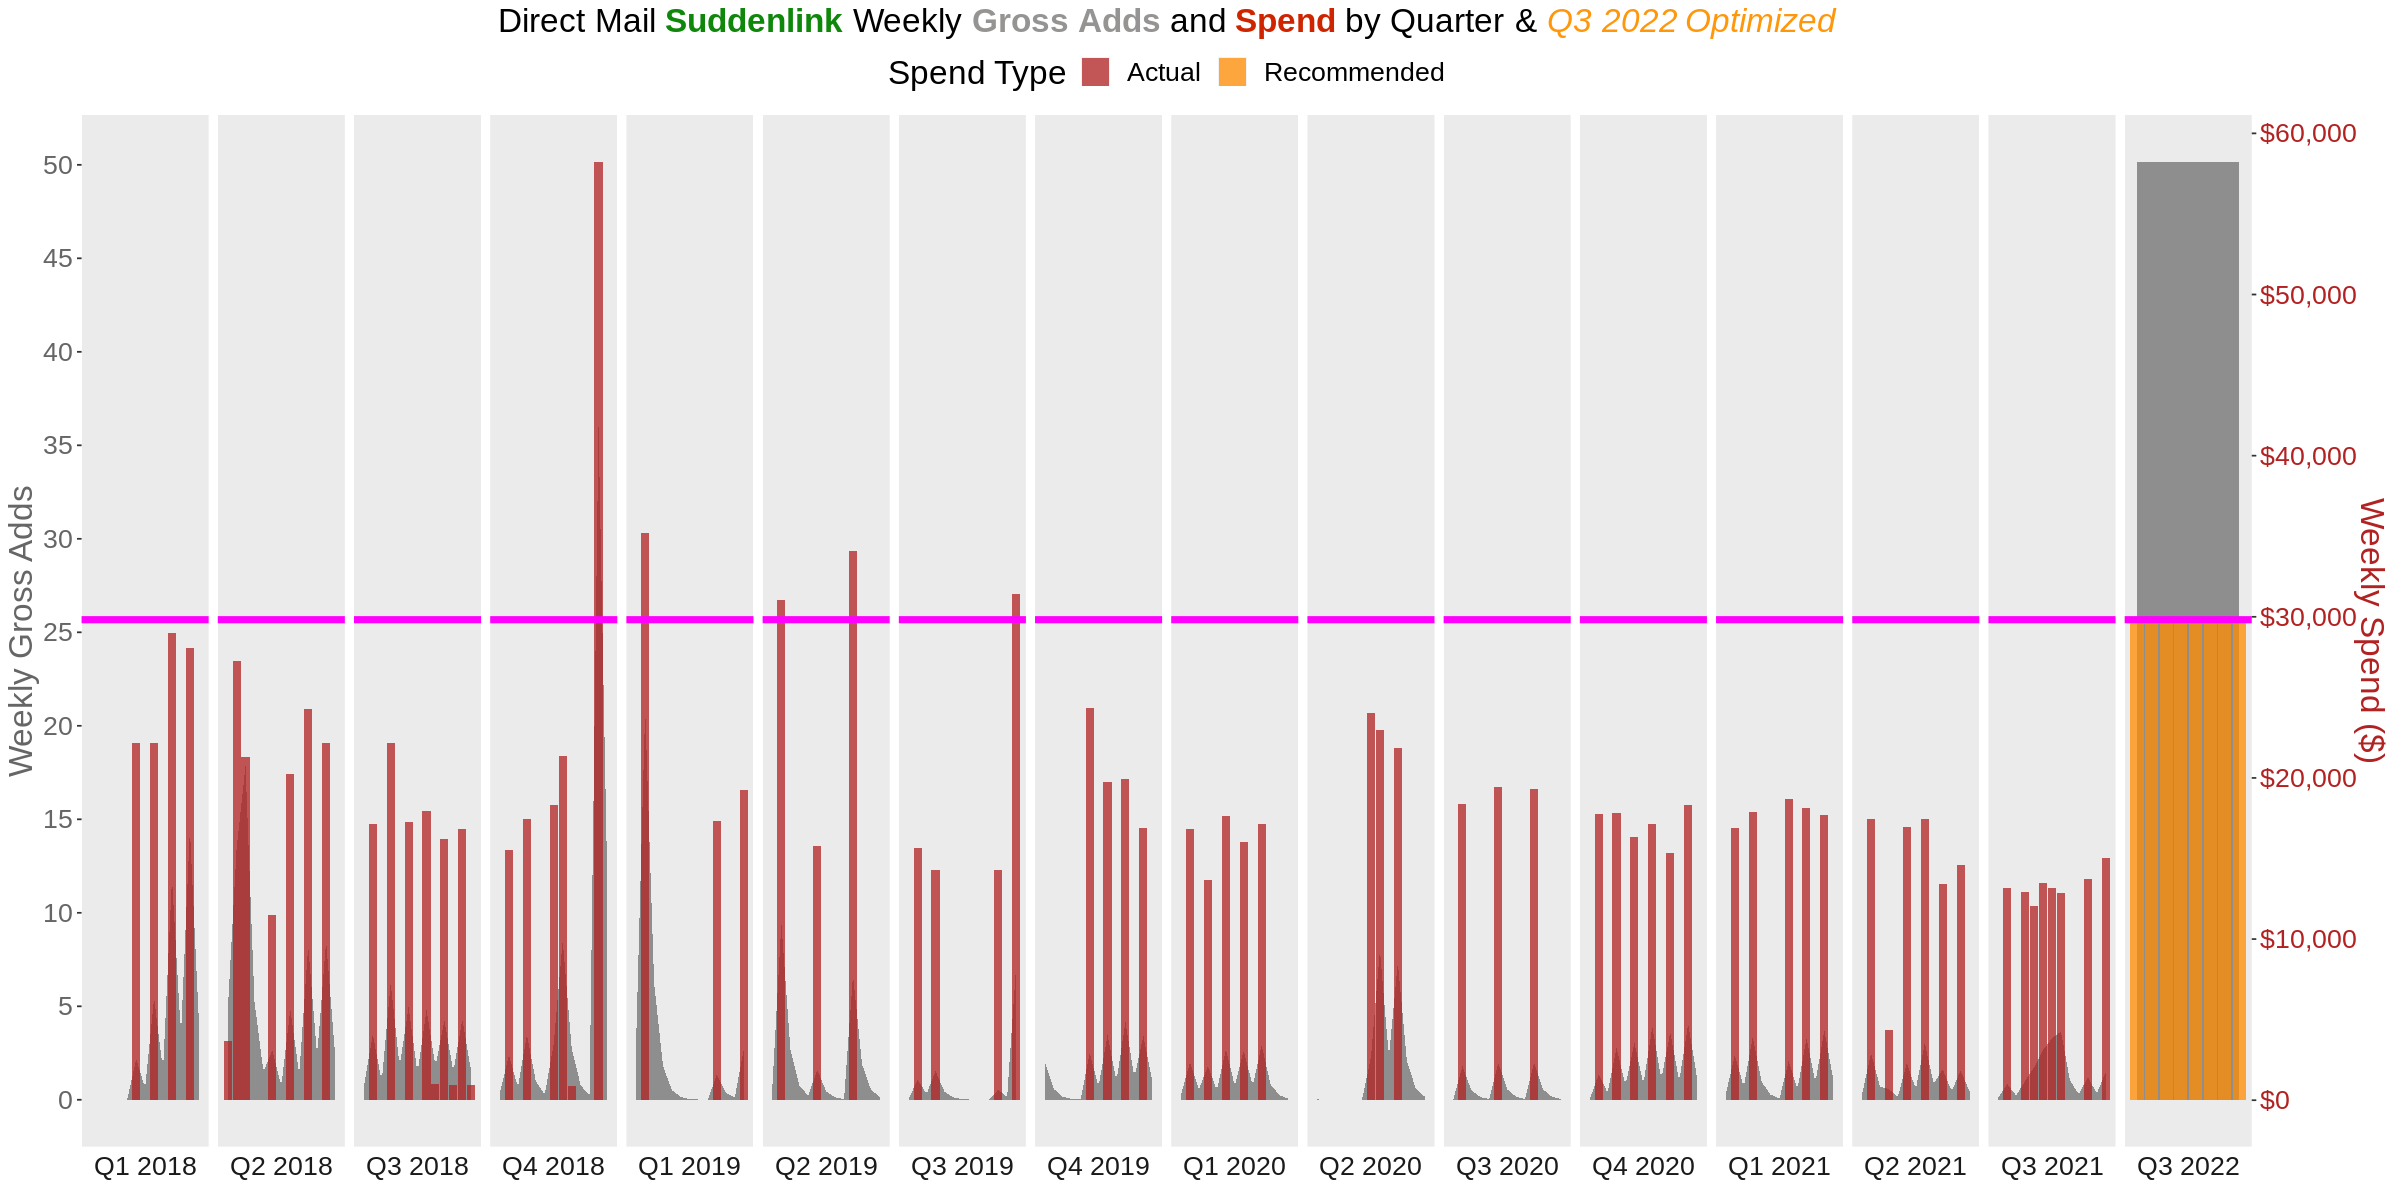

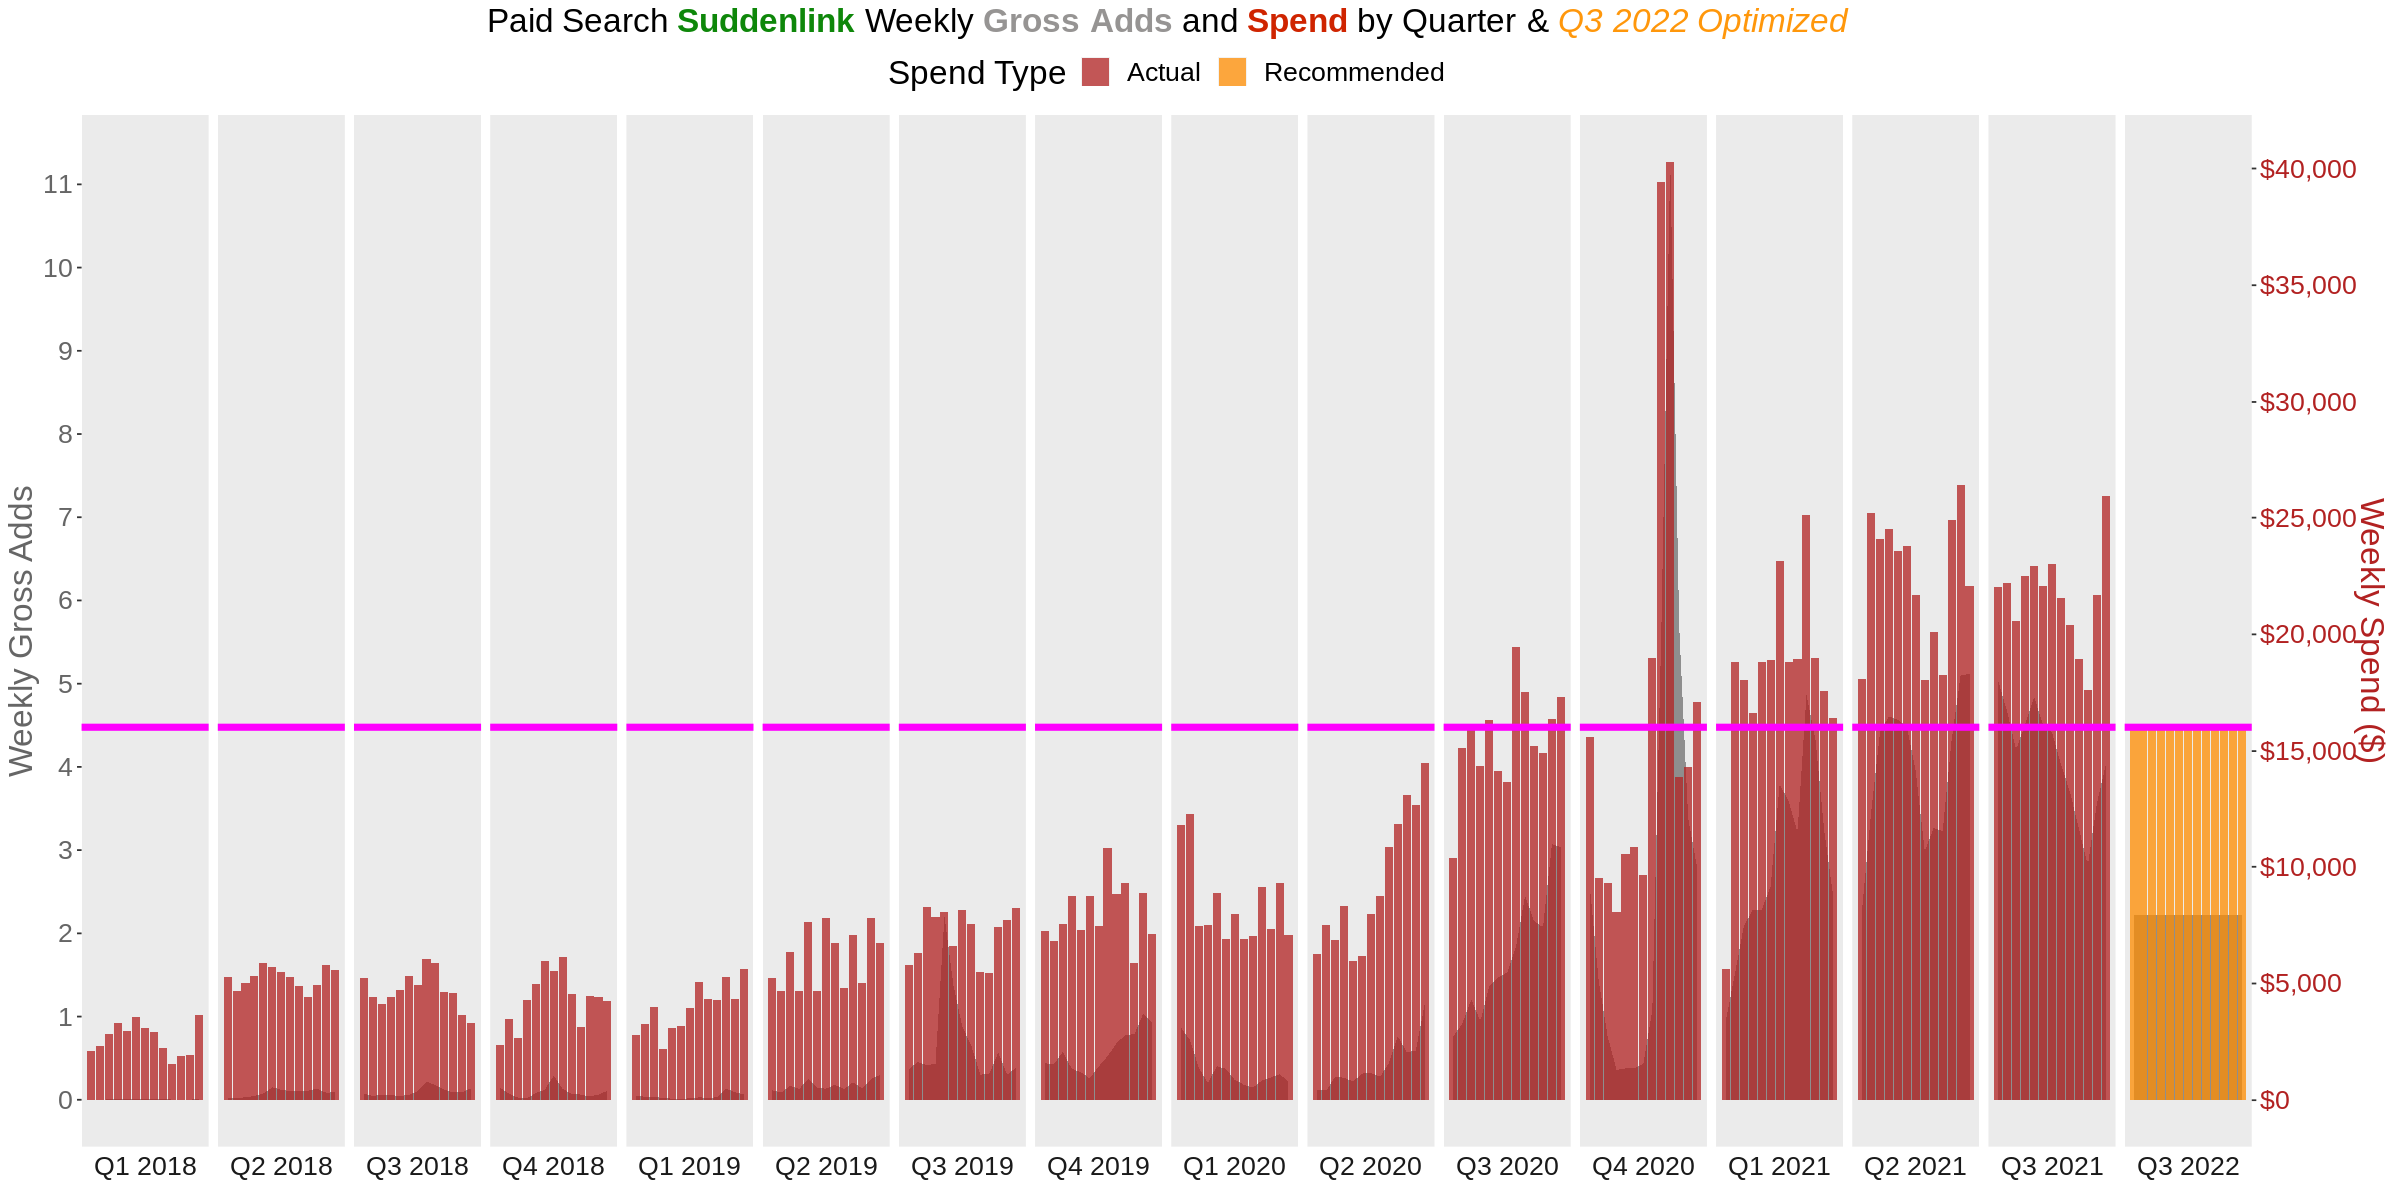

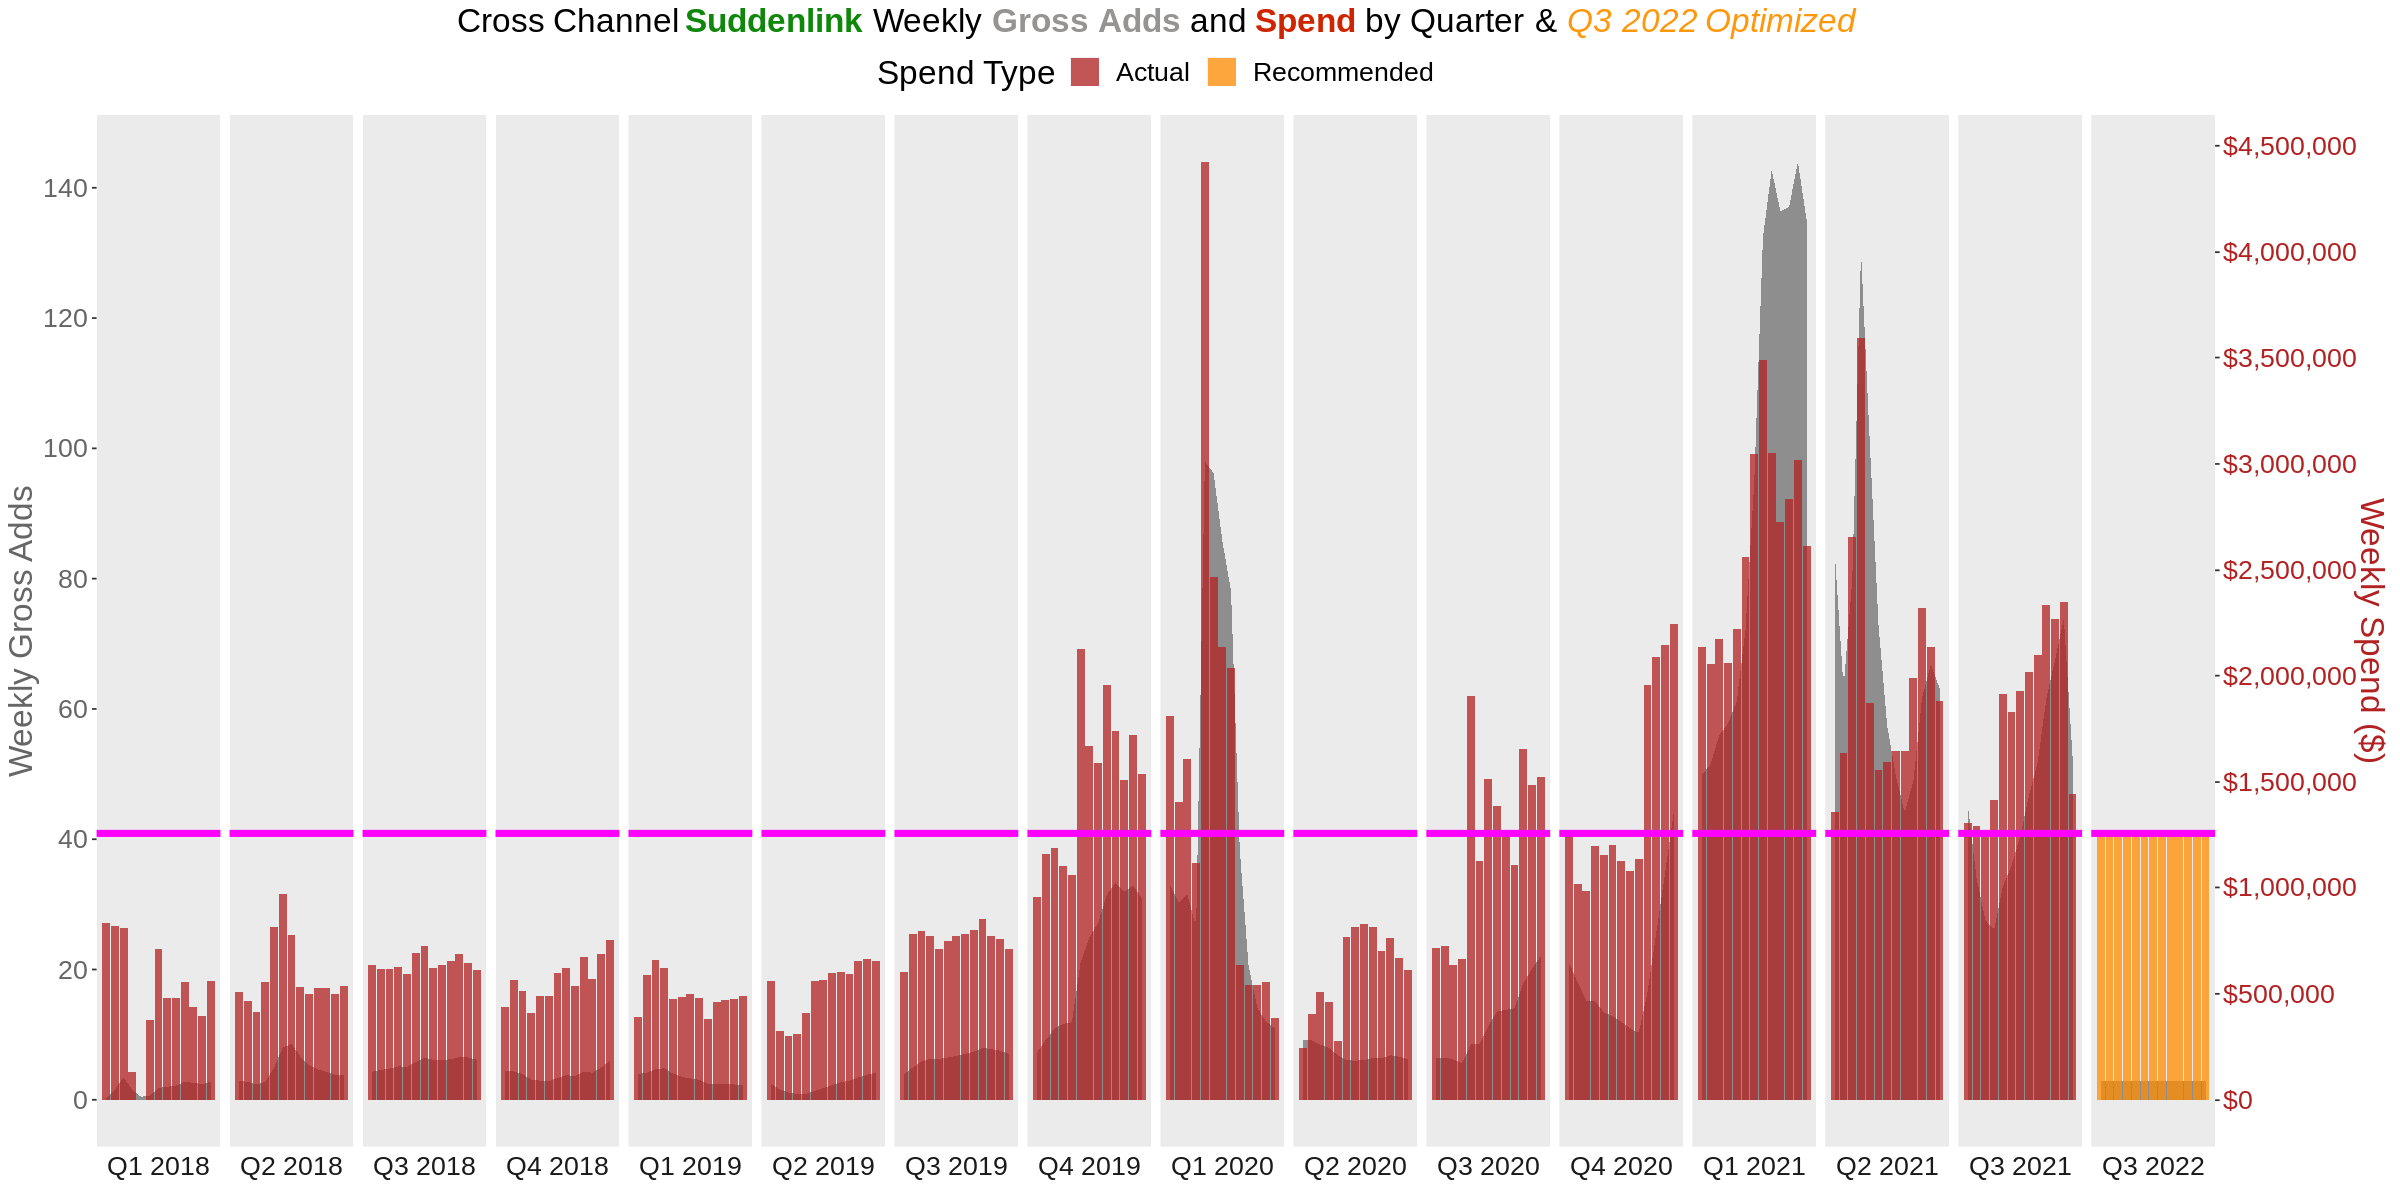

In [84]:
for(media in media_names_vec){
    media_df <- media_spend_target_all %>%
           select(period,dma,matches(media),brand,Spend_Type,Index,qy) %>%
           group_by(Index,period,brand,Spend_Type,qy) %>%
           summarize_at(.vars = vars(-dma),.funs = ~sum(.,na.rm=T)) %>%
           arrange(brand,period,Spend_Type) %>%
           rename_all(.funs = function(x){gsub(paste0(media,'_'),'',x)})
    
    ##For the title formatting the spend in K notation and formatting the CPMTGA as well
    format_spend <- fprint_w_cpmtga %>%
                    filter(Media == media & brand == 'Suddenlink') %>%
                    mutate_at(.vars = vars(Spend),.funs = ~paste0('$',so_formatter(round(.)))) %>%
                    select(Spend) %>%
                    pull()
    
    format_cpmtga <- fprint_w_cpmtga %>%
                    filter(Media == media & brand == 'Suddenlink') %>%
                    mutate_at(.vars = vars(CPMTGA),.funs = ~format_money(.,0)) %>%
                    select(CPMTGA) %>%
                    pull()
    
    format_target <- fprint_w_cpmtga %>%
                      filter(Media == media & brand == 'Suddenlink') %>%
                    mutate_at(.vars = vars(ga),.funs = ~format(round(.),big.mark = ',')) %>%
                    select(ga) %>%
                    pull()
    
    ##Fprint dataframe
    media_df_optimum <- media_df %>%
                   ungroup() %>%
                   filter(brand == 'Suddenlink') %>%
                   select(-brand) %>%
                   mutate(qy = factor(qy,levels = qy_vec))
    
     if(media%in%flight_media_vec){
        n_flight_weeks <- nbr_flight_weeks_sdl
        readjust_flight_df <- media_df_optimum %>%
                   filter(Spend_Type == 'Recommended') %>%
                   head(n_flight_weeks) 
    
        
        media_df_optimum <- media_df_optimum %>%
                   filter(Spend_Type!='Recommended') %>%
                   bind_rows(readjust_flight_df)
    }
    options(repr.plot.width=20, repr.plot.height = 10) 

    
    scaling_fac <- max(media_df_optimum$Spend)/max(media_df_optimum$ga)
    
    media_plot <- media_df_optimum %>%
ggplot(.,aes(x=period)) +
geom_area(aes(y = ga),alpha = 0.5) +
geom_col(aes(y=Spend/scaling_fac,fill = Spend_Type),size = 0.25,alpha = 0.75) +
scale_fill_manual(name = "Spend Type",values=c("firebrick", "darkorange")) +
scale_y_continuous(
    
    # Features of the first axis
    name = "Weekly Gross Adds",
    
    # Add a second axis and specify its features
    sec.axis = sec_axis(~.*scaling_fac, name="Weekly Spend ($)",breaks=scales::breaks_pretty(7),labels=scales::dollar_format()),
    breaks = scales::breaks_pretty(10)
  ) +
#geom_hline(aes(yintercept=LB/scaling_fac),color = 'yellow',size =  2) +
#geom_hline(aes(yintercept=UB/scaling_fac),color = 'yellow',size = 2) +
geom_hline(aes(yintercept=optim/scaling_fac),color = 'magenta',size = 2) +
scale_x_date(breaks = scales::breaks_pretty(10)) +
labs(#title = sprintf("<b style='color:#F327DD'>%s</b>/<b style ='color:#969493'>%s GAs = </b><b style='color:#F327DD'>%s</b><b style='color:#969493'> per GA</b>",format_spend,format_target,format_cpmtga),
     subtitle = sprintf("%s <b style='color:#0E870A'>Suddenlink</b> Weekly <b style ='color:#969493'>Gross Adds</b> and <b style='color:#CF2400'>Spend</b> by Quarter & <i style='color:#FF970B'>%s Optimized</i>",cleaned_names_list[media],quarter_2_optimize))+
theme_gray() +
theme(plot.title = element_markdown(lineheight = 1.5,size = 30),
      plot.subtitle = element_markdown(lineheight = 1.1,hjust = 0.5,size = 20),
      axis.title.x = element_blank(),
     text = element_text(size=20),
     legend.position = "top",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        #plot.background = element_rect(fill = "gray"),
        axis.title.y.right = element_text(color = 'firebrick'),
        axis.text.y.right = element_text(color = 'firebrick'),
        axis.title.y.left = element_text(color = 'gray40'),
        axis.text.y.left = element_text(color = 'gray40'),) +
    facet_grid(.~qy, scales = "free", switch = "x",labeller=quarter_labeller) + 
    theme(strip.placement = "inside",
          strip.background =element_rect(fill="white"))
    
    print(media_plot)
    ggsave(plot = media_plot,filename = paste0('Q32022_Simulated_8w_weekly/Suddenlink_',media,'.png'),width = 20,height = 10)
    
}

In [85]:
media_spend_target_all

period,dma,digital_Spend,DRTV_w_Spend,radio_w_Spend,social_Spend,dm_Spend,paid_search_Spend,cross_channel_imp_Spend,digital_ga,⋯,qy,Spend_Type,Index,digital_optim,DRTV_w_optim,radio_w_optim,social_optim,dm_optim,paid_search_optim,cross_channel_imp_optim
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-12-31,"ABILENE, TX",50.75543,0.000,0.0000,42.32477,0.00,0.87,15719,0.0000003315655,⋯,Q1_2018,Actual,1,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-01-07,"ABILENE, TX",63.53887,0.000,0.0000,46.58670,0.00,127.75,13175,0.0000027610455,⋯,Q1_2018,Actual,2,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-01-14,"ABILENE, TX",108.98063,0.000,0.0000,48.56586,0.00,38.44,13175,0.0000188050502,⋯,Q1_2018,Actual,3,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-01-21,"ABILENE, TX",107.71736,0.000,0.0000,53.77831,0.00,44.81,2013,0.0000414641139,⋯,Q1_2018,Actual,4,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-01-28,"ABILENE, TX",125.06085,0.000,0.0000,77.71279,0.00,17.97,0,0.0000792703593,⋯,Q1_2018,Actual,5,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-02-04,"ABILENE, TX",112.77618,0.000,0.0000,105.09485,701.48,81.08,8522,0.0000971948999,⋯,Q1_2018,Actual,6,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-02-11,"ABILENE, TX",94.92418,0.000,778.7312,121.98327,0.00,18.69,11139,0.0000883566318,⋯,Q1_2018,Actual,7,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-02-18,"ABILENE, TX",97.10130,0.000,0.0000,119.80653,701.48,66.68,18210,0.0000854500117,⋯,Q1_2018,Actual,8,349.8545,0,0,320.0828,925.4231,238.5375,20725.21
2018-02-25,"ABILENE, TX",102.32595,0.000,879.1218,91.78321,0.00,107.30,11266,0.0000893759497,⋯,Q1_2018,Actual,9,349.8545,0,0,320.0828,925.4231,238.5375,20725.21


In [86]:
media_spend_target_all %>%
filter(Spend_Type == 'Actual') %>%
ungroup() %>%
select(period,brand,qy,matches('_Spend'),matches('_ga')) %>%
group_by(period,brand,qy) %>%
summarize_all(sum)%>%
gather(metric, value, digital_Spend:cross_channel_imp_ga) %>% 
  extract(metric, into = c("Media", "Metric"), "(.*)_([^_]+)$") %>% 
 arrange(period,brand) %>%
  spread(Metric, value) %>%
arrange(period,brand,match(Media,media_names_vec)) %>%
mutate_at(.vars = vars('Spend','ga'),.funs = ~round(.,3)) %>%
group_by(period,brand,qy) %>%
mutate(total_weekly_spend = sum(Spend),
        total_weekly_media_ga= sum(ga)) 
#%>%
# write.csv('Weekly_Spend_Target_Long.csv',row.names = F)

period,brand,qy,Media,ga,Spend,total_weekly_spend,total_weekly_media_ga
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2017-12-31,Optimum,Q1_2018,digital,0.048,20149.980,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,DRTV_w,0.000,0.000,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,radio_w,0.000,0.000,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,social,0.000,2772.780,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,dm,0.000,0.000,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,paid_search,0.026,14706.070,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,cross_channel_imp,0.457,5029268.000,5066896.8,0.531
2017-12-31,Suddenlink,Q1_2018,digital,0.002,5545.534,842352.8,0.280
2017-12-31,Suddenlink,Q1_2018,DRTV_w,0.000,0.000,842352.8,0.280


In [87]:
media_spend_target_all %>%
ungroup() %>%
filter(Spend_Type != 'Actual') %>%
select(period) %>%
distinct() %>%
pull()

[1] "2021-09-26" "2021-10-03" "2021-10-10" "2021-10-17" "2021-10-24"
 [6] "2021-10-31" "2021-11-07" "2021-11-14" "2021-11-21" "2021-11-28"
[11] "2021-12-05" "2021-12-12" "2021-12-19"

In [88]:
##Keeping only 8 weeks of Flight Media
flight_weeks_on <- c('2021-09-26','2021-10-10','2021-10-24','2021-11-07','2021-11-14','2021-11-21','2021-12-05','2021-12-19')
flight_weeks_on <- sapply(flight_weeks_on,as.Date,USE.NAMES = F)
media_spend_target_all1 <- media_spend_target_all %>% ungroup() %>% as.data.frame()
media_spend_target_all1[media_spend_target_all1['Spend_Type'] == 'Recommended' & !(media_spend_target_all1$period %in% flight_weeks_on) ,'dm_Spend'] <- 0
media_spend_target_all1[media_spend_target_all1['Spend_Type'] == 'Recommended' & !(media_spend_target_all1$period %in% flight_weeks_on) ,'DRTV_w_Spend'] <- 0
media_spend_target_all1[media_spend_target_all1['Spend_Type'] == 'Recommended' & !(media_spend_target_all1$period %in% flight_weeks_on) ,'radio_w_Spend'] <- 0
media_spend_target_all1 %>%
filter(Spend_Type == 'Recommended' & dma == 'NEW YORK, NY')


period,dma,digital_Spend,DRTV_w_Spend,radio_w_Spend,social_Spend,dm_Spend,paid_search_Spend,cross_channel_imp_Spend,digital_ga,⋯,qy,Spend_Type,Index,digital_optim,DRTV_w_optim,radio_w_optim,social_optim,dm_optim,paid_search_optim,cross_channel_imp_optim
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-09-26,"NEW YORK, NY",39184.62,0,0,20769.23,44714,24008.08,8065006,5.649868,⋯,Q3_2022,Recommended,196,39184.62,0,0,20769.23,44714,24008.08,8065006
2021-10-03,"NEW YORK, NY",39184.62,0,0,20769.23,0,24008.08,8065006,5.649868,⋯,Q3_2022,Recommended,197,39184.62,0,0,20769.23,44714,24008.08,8065006
2021-10-10,"NEW YORK, NY",39184.62,0,0,20769.23,44714,24008.08,8065006,5.649868,⋯,Q3_2022,Recommended,198,39184.62,0,0,20769.23,44714,24008.08,8065006
2021-10-17,"NEW YORK, NY",39184.62,0,0,20769.23,0,24008.08,8065006,5.649868,⋯,Q3_2022,Recommended,199,39184.62,0,0,20769.23,44714,24008.08,8065006
2021-10-24,"NEW YORK, NY",39184.62,0,0,20769.23,44714,24008.08,8065006,5.649868,⋯,Q3_2022,Recommended,200,39184.62,0,0,20769.23,44714,24008.08,8065006
2021-10-31,"NEW YORK, NY",39184.62,0,0,20769.23,0,24008.08,8065006,5.649868,⋯,Q3_2022,Recommended,201,39184.62,0,0,20769.23,44714,24008.08,8065006
2021-11-07,"NEW YORK, NY",39184.62,0,0,20769.23,44714,24008.08,8065006,5.649868,⋯,Q3_2022,Recommended,202,39184.62,0,0,20769.23,44714,24008.08,8065006
2021-11-14,"NEW YORK, NY",39184.62,0,0,20769.23,44714,24008.08,8065006,5.649868,⋯,Q3_2022,Recommended,203,39184.62,0,0,20769.23,44714,24008.08,8065006
2021-11-21,"NEW YORK, NY",39184.62,0,0,20769.23,44714,24008.08,8065006,5.649868,⋯,Q3_2022,Recommended,204,39184.62,0,0,20769.23,44714,24008.08,8065006


In [89]:
#All Spend
##Actual Spend - Long
all_spend_long <- media_spend_target_all1 %>%
#filter(Spend_Type == 'Actual') %>%
ungroup() %>%
select(period,brand,qy,matches('_Spend'),matches('_ga')) %>%
group_by(period,brand,qy) %>%
summarize_all(sum)%>%
gather(metric, value, digital_Spend:cross_channel_imp_ga) %>% 
  extract(metric, into = c("Media", "Metric"), "(.*)_([^_]+)$") %>% 
 arrange(period,brand) %>%
  spread(Metric, value) %>%
arrange(period,brand,match(Media,media_names_vec)) %>%
mutate_at(.vars = vars('Spend','ga'),.funs = ~round(.,3)) %>%
group_by(period,brand,qy) %>%
mutate(total_weekly_spend = sum(Spend),
       total_weekly_media_ga= sum(ga),
      qy = factor(qy,levels = qy_vec)) #%>%
#write.csv('Weekly_Spend_Target_Long.csv',row.names = F)
all_spend_long

period,brand,qy,Media,ga,Spend,total_weekly_spend,total_weekly_media_ga
<date>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2017-12-31,Optimum,Q1_2018,digital,0.048,20149.980,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,DRTV_w,0.000,0.000,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,radio_w,0.000,0.000,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,social,0.000,2772.780,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,dm,0.000,0.000,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,paid_search,0.026,14706.070,5066896.8,0.531
2017-12-31,Optimum,Q1_2018,cross_channel_imp,0.457,5029268.000,5066896.8,0.531
2017-12-31,Suddenlink,Q1_2018,digital,0.002,5545.534,842352.8,0.280
2017-12-31,Suddenlink,Q1_2018,DRTV_w,0.000,0.000,842352.8,0.280


In [90]:
display_order <- c('dm','radio_w','DRTV_w','social','paid_search','digital')

In [ ]:
options(repr.plot.width=20, repr.plot.height = 10) 

all_spend_plot <- all_spend_long %>%
filter(brand == 'Optimum') %>%
filter(!Media%in%c('cross_channel_imp','email_sent_w')) %>%
arrange(period,qy,match(Media,display_order)) %>%
mutate(Media = factor(Media,levels = display_order))  %>%
mutate_at(.vars = vars(Media), .funs = ~recode(., !!!cleaned_names_list)) %>%

ggplot(.,aes(x = period)) +
geom_col(aes(y=Spend,fill = Media),size = 0.25,alpha = 0.75) +
#scale_color_manual(labels = cleaned_nam, values = col2state$c) +
theme_gray() +
theme(plot.title = element_markdown(lineheight = 1.5,size = 30),
      plot.subtitle = element_markdown(lineheight = 1.1,hjust = 0.5,size = 20),
      axis.title.x = element_blank(),
     text = element_text(size=20),
     legend.position = "right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        #plot.background = element_rect(fill = "gray"),
        axis.title.y.right = element_text(color = 'firebrick'),
        axis.text.y.right = element_text(color = 'firebrick'),
        axis.title.y.left = element_text(color = 'gray40'),
        axis.text.y.left = element_text(color = 'gray40'),) +
    facet_grid(.~qy, scales = "free", switch = "x",labeller=quarter_labeller) + 
    theme(strip.placement = "inside",
          strip.background =element_rect(fill="white"))
ggsave(plot = all_spend_plot,filename ='Q32022_Simulated_8w_weekly/Optimum_All_Spend.png',width = 20,height = 10)

Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


In [ ]:
options(repr.plot.width=20, repr.plot.height = 10) 

all_spend_plot <- all_spend_long %>%
filter(brand == 'Suddenlink') %>%
filter(!Media%in%c('cross_channel_imp','email_sent_w')) %>%
arrange(period,qy,match(Media,display_order)) %>%
mutate(Media = factor(Media,levels = display_order))  %>%
mutate_at(.vars = vars(Media), .funs = ~recode(., !!!cleaned_names_list)) %>%
ggplot(.,aes(x = period)) +
geom_col(aes(y=Spend,fill = Media),size = 0.25,alpha = 0.75) +
#scale_color_manual(labels = cleaned_nam, values = col2state$c) +
theme_gray() +
theme(plot.title = element_markdown(lineheight = 1.5,size = 30),
      plot.subtitle = element_markdown(lineheight = 1.1,hjust = 0.5,size = 20),
      axis.title.x = element_blank(),
     text = element_text(size=20),
     legend.position = "right",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        #plot.background = element_rect(fill = "gray"),
        axis.title.y.right = element_text(color = 'firebrick'),
        axis.text.y.right = element_text(color = 'firebrick'),
        axis.title.y.left = element_text(color = 'gray40'),
        axis.text.y.left = element_text(color = 'gray40'),) +
    facet_grid(.~qy, scales = "free", switch = "x",labeller=quarter_labeller) + 
    theme(strip.placement = "inside",
          strip.background =element_rect(fill="white"))
ggsave(plot = all_spend_plot,filename ='Q32022_Simulated_8w_weekly/Suddenlink_All_Spend.png',width = 20,height = 10)